In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
import graphing as g
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import pyperclip as clipbd
from scipy import signal
import matplotlib
import seaborn as sns

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [3]:
import alldata_20200526 as ad
import pickle as pik

In [4]:
full_list_seq =  ['AC01_04',
            'AC01_05',
            'AC01_06',
            'AC01_10',
             
            'AC03_04',
            'AC03_06',
            'AC03_09',
            'AC03_14',
            'AC03_15',
            'AC03_18',
            'AC03_20',
            'AC03_21',
            'AC03_22',
            'AC03_23',
             
            'AC04_03']

In [5]:
#g.loadSingleFrog_wsmoothed('AC01_05')
with open(ad.data_allfiles['AC01_05']['zoominfo'], 'rb') as f:
    scale = pik.load(f)
    waterlevel= pik.load(f)
    newwaterlevel= pik.load(f)
    bright= pik.load(f)

In [6]:
waterlevel

648

In [7]:
newwaterlevel

681

In [6]:
def extract_gaits(data):
    "returns gait information in frames"
    ftt=1
    HL_a = [(x*ftt, y*ftt) for (x, y) in data['HL_a']]
    HL_t = [(x*ftt, y*ftt) for (x, y) in data['HL_t']]
    FL_t = [(x*ftt, y*ftt) for (x, y) in data['FL_t']]
    FL_a = [(x*ftt, y*ftt) for (x, y) in data['FL_a']]
    return {'HL_a':HL_a, 'HL_t': HL_t, 'FL_a':FL_a, 'FL_t':FL_t}

def has_strict_jump_cycle(data):
    gaits = extract_gaits(data)
    if len(gaits['HL_a']) >= 2:
        return True
    else:
        return False

def get_list_strict_jump_cyc():
    final_list = [frog for frog in full_list_seq if has_strict_jump_cycle(g.loadSingleFrog_wsmoothed(frog))]
    return final_list

In [7]:
def above_below_water_range(data, jmp_strict_def = False):
    above = []
    below = []
    #these are the index of water contact
    wc_idx = data['watercontactIdx'][0].flatten()
    #we want to auto-generate each range and check if it the y value > 0
    ####print(wc_idx, len(wc_idx))
    
    #jmp_strict_def if True will only return the ranges included in the
    # strinct jump definition (HL_a to HL_a)
    [(HL_a_fr_s, _), (HL_a_fr_end, _)] = data['HL_a']
    HL_a_idx_start = list(data['frameno']).index(HL_a_fr_s)
    HL_a_idx_end = list(data['frameno']).index(HL_a_fr_end)
    ##print(HL_a_idx_start, HL_a_idx_end)
    
    for i in range(len(wc_idx) + 1):
        ##print(i)
        if i == 0: #first value
            startidx = 0
            endidx = wc_idx[i]
        elif i == (len(wc_idx)):# last value
            startidx = wc_idx[i-1]
            endidx = -1
        else: #middle value
            startidx = wc_idx[i-1]
            endidx = wc_idx[i]
        thesum= np.sum(data['s_mnty'][startidx:endidx])
        ##print('%d:%d --- %s' %(startidx, endidx, thesum > 0))
        
        if jmp_strict_def:
            #Before the segment, skip this range:
            if endidx < HL_a_idx_start:
                continue
            #After the segnebtm skip this rangeL
            if startidx > HL_a_idx_end:
                continue
            if startidx < HL_a_idx_start:
                startidx = HL_a_idx_start
            if endidx > HL_a_idx_end:
                endidx = HL_a_idx_end
               
        if thesum > 0:
            above += [(startidx, endidx)]
        else:
            below += [(startidx, endidx)]
    return above, below

In [10]:
strict_jump_list = get_list_strict_jump_cyc()
print(strict_jump_list)

['AC01_05', 'AC01_06', 'AC01_10', 'AC03_04', 'AC03_15', 'AC03_18', 'AC03_20', 'AC03_21', 'AC03_22', 'AC03_23', 'AC04_03']


AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


Text(0.5, 0, 'Range (cm)')

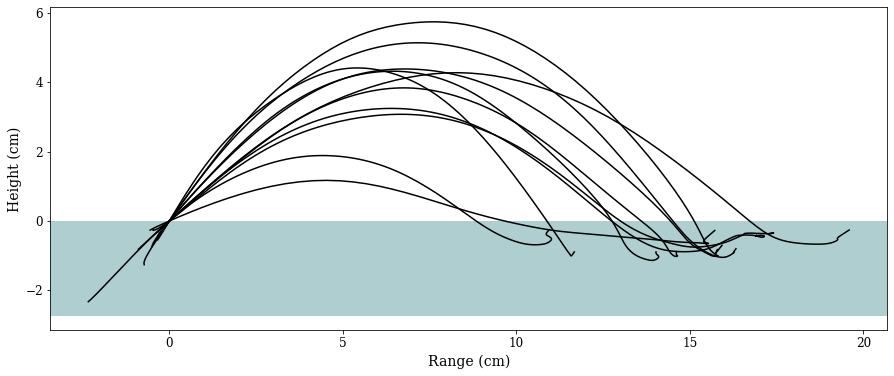

In [23]:
color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

fig, ax = plt.subplots(nrows = 1, figsize = (15,10), sharex = True)

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    frogsize = data['frogsize(cm)']
      
    
    v_smntx=np.gradient(s_mntx, data['time'])
    v_smnty= np.gradient(s_mnty, data['time'])
    v_total = np.sqrt(v_smntx**2 + v_smnty**2)
    v_angle = np.rad2deg(np.arctan2(v_smnty, v_smntx))
    
    v_smntx =v_smntx/data['pxSVL']*frogsize 
    v_smnty =v_smnty/data['pxSVL']*frogsize
    v_total =v_total/data['pxSVL']*frogsize 
    
    time = data['time']
    frameno = data['frameno']
    
    aboveidx, belowidx = above_below_water_range(data, True)
    
    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    
    #plotting aligning water exit
    waterexit_x = s_mntx[b4_belowidx_e]
    waterexit_y = s_mnty[b4_belowidx_e]
    
    plt.plot((s_mntx[b4_belowidx_s:af_belowidx_e] - waterexit_x)/data['pxSVL']*frogsize , (s_mnty[b4_belowidx_s:af_belowidx_e] - waterexit_y)/data['pxSVL']*frogsize , c ='k' )
ax.set_aspect('equal', 'box')
[ymin, ymax] = ax.get_ylim()
ax.axhspan(ymin,0, facecolor='cadetblue', alpha = .5, zorder = 0, clip_on=False)
ax.set_ylabel('Height (cm)')
ax.set_xlabel('Range (cm)')

In [25]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig.savefig('Figures/strict_jmp_xvy.pdf', transparent =True)

In [29]:
monochrome = (cycler('color', ['k']) * cycler('marker', ['', '.']) *
              cycler('linestyle', ['-', '--', ':', '-.']))

(array([<AxesSubplot:title={'center':'AC03_23'}, ylabel='Horizontal\nposition\n(cm)'>,
        <AxesSubplot:ylabel='Vertical\nposition\n(cm)'>,
        <AxesSubplot:ylabel='Body\nAngle\n(deg)'>,
        <AxesSubplot:xlabel='Time (ms)', ylabel='Gait'>], dtype=object),
 <Figure size 720x1152 with 4 Axes>)

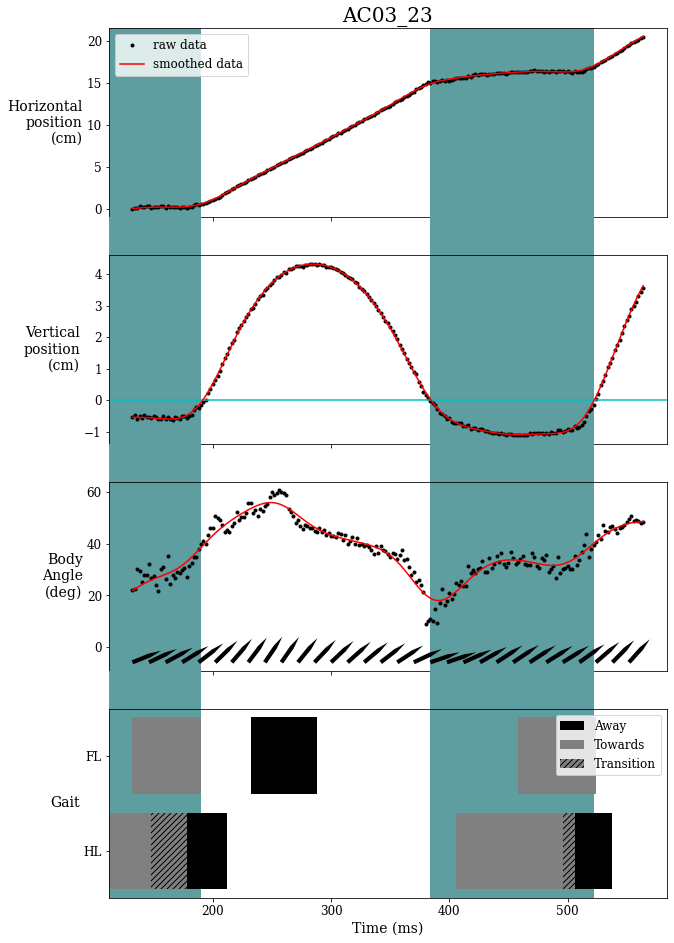

In [7]:
g.graph_all('AC03_23')

AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


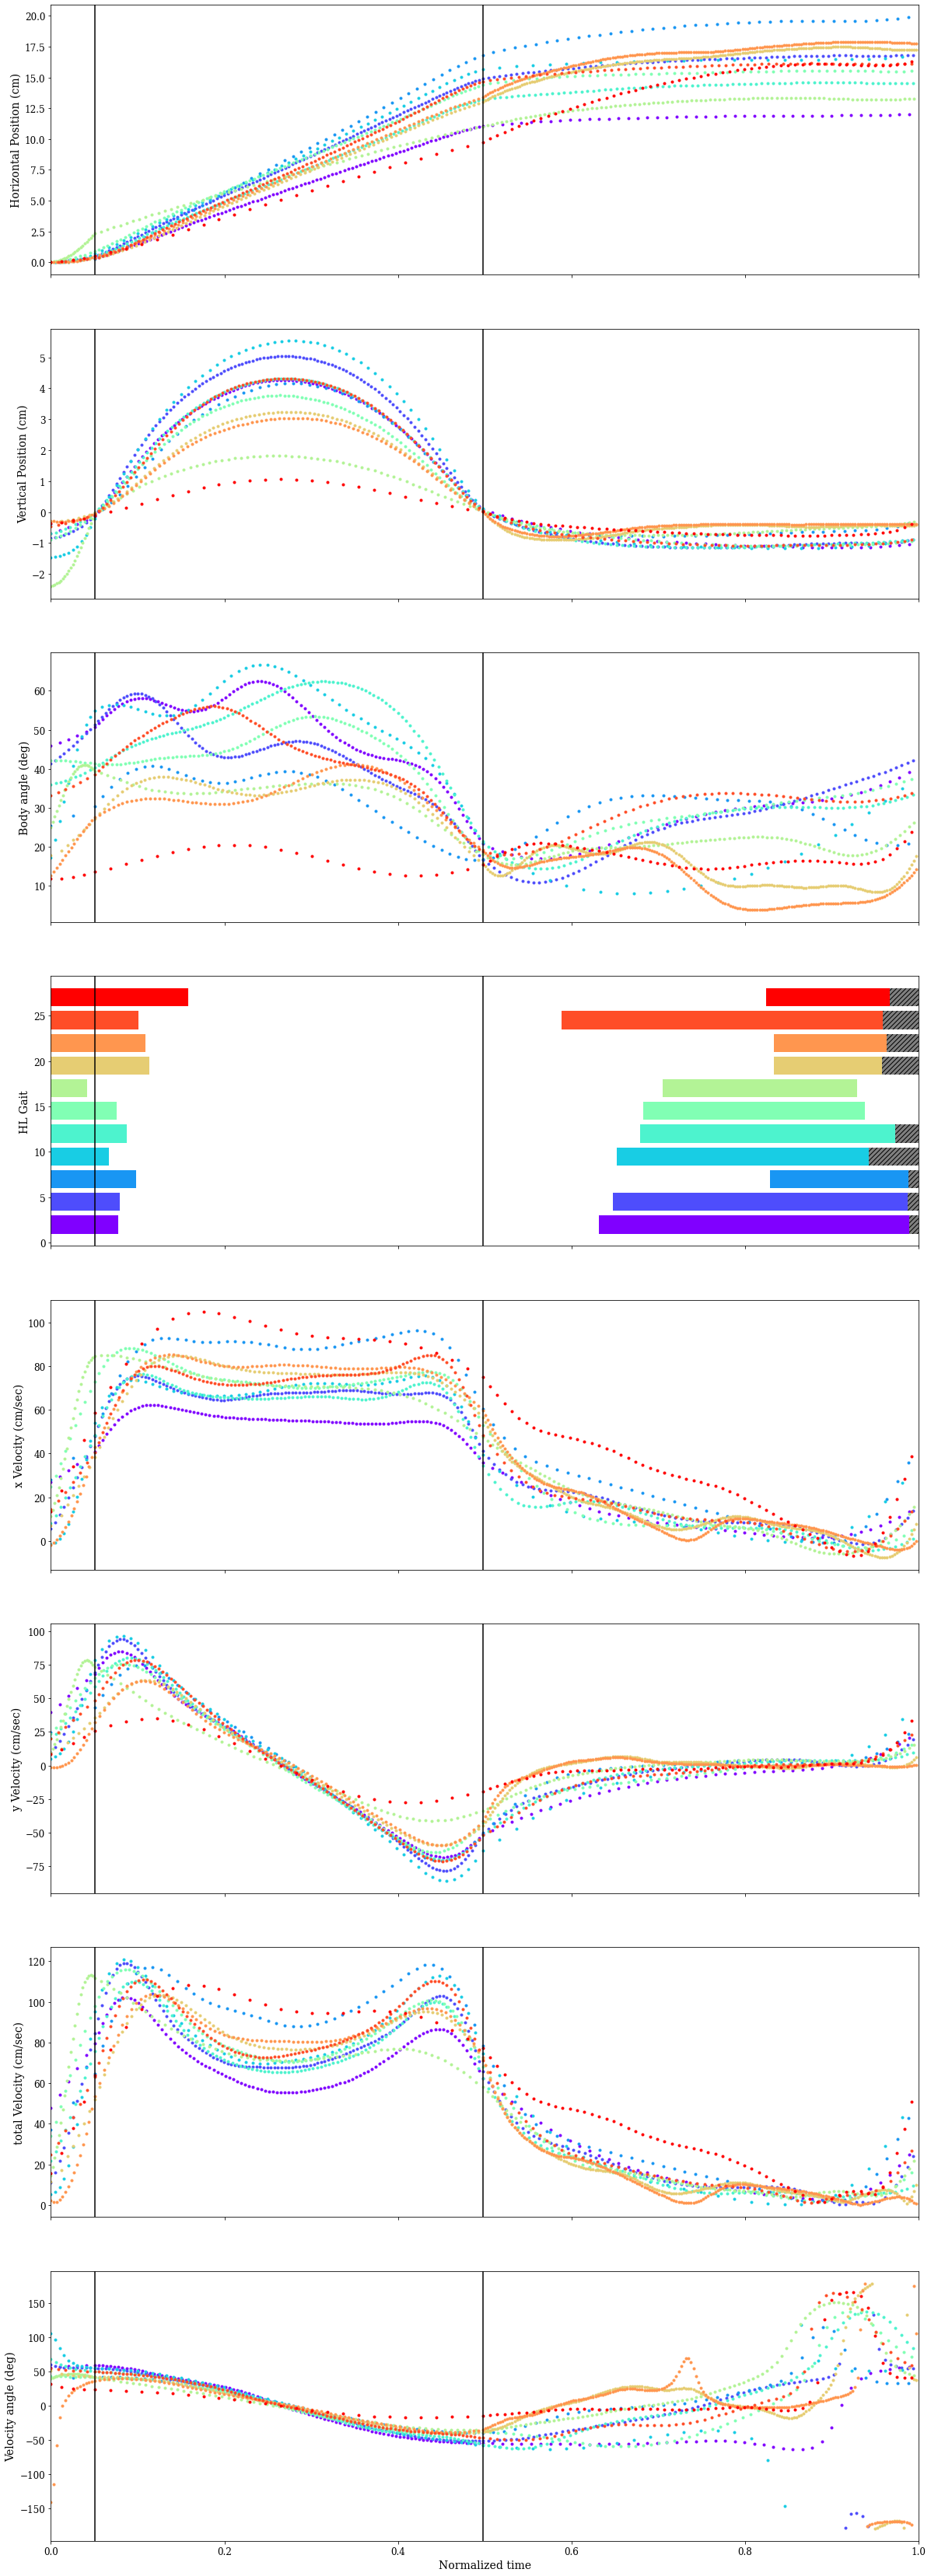

In [57]:
b4time = .018032
abovetime = .159143
aftime = .178889

totaltime = b4time + abovetime + aftime
ratio_b4 = b4time/totaltime
ratio_above = abovetime/totaltime
ratio_af = aftime/totaltime

fig, ax = plt.subplots(nrows = 8, figsize = (20,60), sharex = True)

color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))
#from cycler import cycler
#monochrome = (cycler('color', ['k']) * cycler('marker', ['', '.']) *
 #             cycler('linestyle', ['-', '--', ':', '-.']))
#plt.rc('axes', prop_cycle=monochrome)

initgait = 1

#ratio_b4 = 1
#ratio_above=1
#ratio_af = 1

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    frogsize = data['frogsize(cm)']
      
    
    v_smntx=np.gradient(s_mntx, data['time'])
    v_smnty= np.gradient(s_mnty, data['time'])
    v_total = np.sqrt(v_smntx**2 + v_smnty**2)
    v_angle = np.rad2deg(np.arctan2(v_smnty, v_smntx))
    
    v_smntx =v_smntx/data['pxSVL']*frogsize 
    v_smnty =v_smnty/data['pxSVL']*frogsize
    v_total =v_total/data['pxSVL']*frogsize 
    
    time = data['time']
    frameno = data['frameno']
    
    
    aboveidx, belowidx = above_below_water_range(data, True)

    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    initx = s_mntx[b4_belowidx_s]
    #below_before
    min_timeb4 = time[b4_belowidx_s]
    max_timeb4 = time[b4_belowidx_e] - min_timeb4
    
    below_b4_time = (time[b4_belowidx_s:b4_belowidx_e] - min_timeb4)/max_timeb4 *ratio_b4
    
    ax[2].plot(below_b4_time, s_mnta[b4_belowidx_s:b4_belowidx_e], '.', c=c)
    ax[0].plot(below_b4_time, (s_mntx[b4_belowidx_s:b4_belowidx_e] - initx)/data['pxSVL']*frogsize, '.', c=c)
    ax[1].plot(below_b4_time, (s_mnty[b4_belowidx_s:b4_belowidx_e])/data['pxSVL']*frogsize, '.', c=c)
    ax[4].plot(below_b4_time, v_smntx[b4_belowidx_s:b4_belowidx_e], '.', c=c)
    ax[5].plot(below_b4_time, v_smnty[b4_belowidx_s:b4_belowidx_e], '.', c=c)
    ax[6].plot(below_b4_time, v_total[b4_belowidx_s:b4_belowidx_e], '.', c=c)
    ax[7].plot(below_b4_time, v_angle[b4_belowidx_s:b4_belowidx_e], '.', c=c)
    
    #above
    min_timeab = time[aboveidx_s]
    max_timeab = time[aboveidx_e] - min_timeab
    
    af_time = (time[aboveidx_s:aboveidx_e] - min_timeab)/max_timeab *ratio_above
    
    af_time = af_time + ratio_b4
    
    ax[2].plot(af_time, s_mnta[aboveidx_s:aboveidx_e], '.', c=c)
    ax[0].plot(af_time, (s_mntx[aboveidx_s:aboveidx_e] - initx)/data['pxSVL']*frogsize, '.', c=c)
    ax[1].plot(af_time, (s_mnty[aboveidx_s:aboveidx_e])/data['pxSVL']*frogsize, '.', c=c)
    ax[4].plot(af_time, v_smntx[aboveidx_s:aboveidx_e], '.', c=c)
    ax[5].plot(af_time, v_smnty[aboveidx_s:aboveidx_e], '.', c=c)
    ax[6].plot(af_time, v_total[aboveidx_s:aboveidx_e], '.', c=c)
    ax[7].plot(af_time, v_angle[aboveidx_s:aboveidx_e], '.', c=c)
   
    #below_after
    min_timeaf = time[af_belowidx_s]
    max_timeaf = time[af_belowidx_e] - min_timeaf
    
    below_af_time = (time[af_belowidx_s:af_belowidx_e] - min_timeaf)/max_timeaf *ratio_af
    
    below_af_time = below_af_time + ratio_above + ratio_b4#af_time[-1]
    
    ax[2].plot(below_af_time, s_mnta[af_belowidx_s:af_belowidx_e], '.', c=c)
    ax[0].plot(below_af_time, (s_mntx[af_belowidx_s:af_belowidx_e] - initx)/data['pxSVL']*frogsize, '.', c=c)
    ax[1].plot(below_af_time, (s_mnty[af_belowidx_s:af_belowidx_e])/data['pxSVL']*frogsize, '.', c=c)
    ax[4].plot(below_af_time, v_smntx[af_belowidx_s:af_belowidx_e], '.', c=c)
    ax[5].plot(below_af_time, v_smnty[af_belowidx_s:af_belowidx_e], '.', c=c)
    ax[6].plot(below_af_time, v_total[af_belowidx_s:af_belowidx_e], '.', c=c)
    ax[7].plot(below_af_time, v_angle[af_belowidx_s:af_belowidx_e], '.', c=c)
    
    
    #####################GAITS

    
    def scale_gaits(theval):
        start = theval[0]
        end = theval[0] + theval[1]
        
       # print(theval)
       # print(start, end)
        
        if  start <= b4_belowidx_e:
            start = (data['time'][start] - min_timeb4)/max_timeb4*ratio_b4
        elif aboveidx_s <= start <= aboveidx_e:
            start = (data['time'][start] - min_timeab)/max_timeab*ratio_above + ratio_b4
        elif af_belowidx_s <= start:# <= af_belowidx_e:
            start = (data['time'][start] - min_timeaf)/max_timeaf*ratio_af+ ratio_b4+ ratio_above
        #else:
        #    start = 0
            
        if  end <= b4_belowidx_e:
             end = (data['time'][end] - min_timeb4)/max_timeb4*ratio_b4
        elif aboveidx_s <= end <= aboveidx_e:
             end = (data['time'][end] - min_timeab)/max_timeab*ratio_above + ratio_b4
        elif af_belowidx_s <= end: #<= af_belowidx_e:
             end = (data['time'][end] - min_timeaf)/max_timeaf*ratio_af+ ratio_b4+ ratio_above
        #else:
        #    end = 0
        #print(start, end)
        return [start, end-start]
  
    #print('a', data['HL_t'])
    
    HL_a = [(list(data['frameno']).index(x), y) for (x, y) in data['HL_a']]
    HL_t = [(list(data['frameno']).index(x), y) for (x, y) in data['HL_t'] if x in data['frameno']]
   
   # print('b', HL_t)
    
    HL_a = [scale_gaits(x) for x in HL_a]
    HL_t = [scale_gaits(x) for x in HL_t]
   # print('c', HL_t)
    
    
    

        
    for t_val in HL_t:
        for a_val in HL_a:
            if np.abs(a_val[0] - (t_val[0] + t_val[1])) < 25/data['fps']:
                #print(t_val, a_val)
                start = (t_val[0] + t_val[1])
                end = a_val[0] - start
                    
                
                hatch_bar = ax[3].broken_barh([(start, end)], (initgait, 2), facecolors='gray', hatch='////')
        
        
    black_bar = ax[3].broken_barh(HL_a, (initgait, 2), facecolors=c)
    gray_bar = ax[3].broken_barh(HL_t, (initgait, 2), facecolors=c)
#     #ax[3].broken_barh(FL_a, (initgait + 2.5, 2), facecolors='black')
#     #ax[3].broken_barh(FL_t, (initgait + 2.5, 2), facecolors='gray')
    
    initgait = initgait + 2.5
    
    
    
    ###################Max velocity
#     #Idx of max velocity
#     #MaxVelIdx = np.where(v_total == np.max(v_total[aboveidx_s:aboveidx_e]))
#     #05/2021: the above gives incorrect place in rare case where velocity has 2 peaks
#     vtot = v_total*data['pxSVL']*frogsize
#     peak, k = signal.find_peaks(vtot[b4_belowidx_s:af_belowidx_e], prominence=data['fps'])
#     print(peak)
     
#     if len(peak) > 0:
#         #if len(peak) > 2:
#             #pass
#             #MaxVelIdx = np.where(vtot == vtot[b4_belowidx_s:af_belowidx_e][peak[1]])[0][0]
#         #else:
#          MaxVelIdx = np.where(vtot == vtot[b4_belowidx_s:af_belowidx_e][peak[0]])[0][0]
#     else:
#         MaxVelIdx= 5   
#     print('MaxVelIdx: %d' %MaxVelIdx)
#     fixed_maxidx = scale_gaits((MaxVelIdx, 0))
    
#     ax[6].axvline(fixed_maxidx[0], c = c)
#     ax[3].axvline(fixed_maxidx[0], c = c)
    
#     vtot = v_smnty*data['pxSVL']*frogsize
#     peak, k = signal.find_peaks(vtot[b4_belowidx_s:af_belowidx_e], prominence=data['fps'])
#     print(peak)
     
#     if len(peak) > 0:
#         #if len(peak) > 2:
#             #pass
#             #MaxVelIdx = np.where(vtot == vtot[b4_belowidx_s:af_belowidx_e][peak[1]])[0][0]
#         #else:
#          MaxVelIdx = np.where(vtot == vtot[b4_belowidx_s:af_belowidx_e][peak[0]])[0][0]
#     else:
#         MaxVelIdx= 5   
#     print('MaxVelIdx: %d' %MaxVelIdx)
#     fixed_maxidx = scale_gaits((MaxVelIdx, 0))
    
#     ax[5].axvline(fixed_maxidx[0], c = c)
#     ax[3].axvline(fixed_maxidx[0], c = c)
    
    

ax[0].set_ylabel("Horizontal Position (cm)")    
ax[1].set_ylabel("Vertical Position (cm)")    
ax[2].set_ylabel("Body angle (deg)")
ax[3].set_ylabel("HL Gait")
ax[4].set_ylabel("x Velocity (cm/sec)")
ax[5].set_ylabel("y Velocity (cm/sec)")
ax[6].set_ylabel("total Velocity (cm/sec)")
ax[7].set_ylabel('Velocity angle (deg)')
ax[7].set_xlabel('Normalized time')
ax[7].set_xbound(0, 1)

#waterline
for axs in ax:
    axs.axvline(ratio_b4)
    axs.axvline(ratio_above + ratio_b4)
    #axs.set_xbound(0, 3)
    
    
#max velocity?
# ax[4].axvline()
# ax[5]
# ax[6]

#ax.set_xticks([0.5, 1.5, 2.5])
#ax.set_xticklabels(['B4_below', 'above', 'AF_below'])

In [58]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig.savefig('Figures/allthings_allnorm_ratio.pdf', transparent=True)

AC01_05 : (7, 12) - (12, 110) - (110, 155)
AC01_06 : (90, 100) - (100, 208) - (208, 285)
AC01_10 : (125, 127) - (127, 174) - (174, 215)
AC03_04 : (11, 21) - (21, 75) - (75, 101)
AC03_15 : (41, 50) - (50, 146) - (146, 221)
AC03_18 : (20, 29) - (29, 119) - (119, 176)
AC03_20 : (21, 43) - (43, 104) - (104, 196)
AC03_21 : (153, 160) - (160, 245) - (245, 423)
AC03_22 : (201, 216) - (216, 300) - (300, 478)
AC03_23 : (23, 29) - (29, 126) - (126, 187)
AC04_03 : (38, 42) - (42, 67) - (67, 127)


Text(0, 0.5, 'Body angle (deg)')

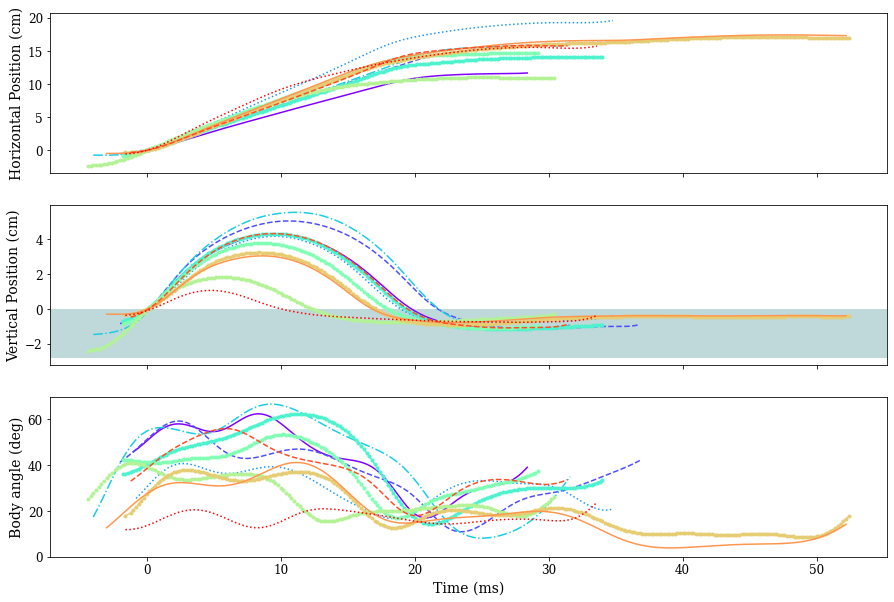

In [48]:
color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

fig, ax = plt.subplots(nrows = 3, figsize = (15,10), sharex = True)

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    frogsize = data['frogsize(cm)']
      
    
    v_smntx=np.gradient(s_mntx, data['time'])
    v_smnty= np.gradient(s_mnty, data['time'])
    v_total = np.sqrt(v_smntx**2 + v_smnty**2)
    v_angle = np.rad2deg(np.arctan2(v_smnty, v_smntx))
    
    v_smntx =v_smntx/data['pxSVL']*frogsize 
    v_smnty =v_smnty/data['pxSVL']*frogsize
    v_total =v_total/data['pxSVL']*frogsize 
    
    time = data['time']
    frameno = data['frameno']
    
    aboveidx, belowidx = above_below_water_range(data, True)
    
    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    
    #plotting aligning water exit
    waterexit_t = time[b4_belowidx_e]
    
    ax[0].plot((time[b4_belowidx_s:af_belowidx_e] - waterexit_t)*100, (s_mntx[b4_belowidx_s:af_belowidx_e] - s_mntx[b4_belowidx_e])/data['pxSVL']*frogsize , color=c)
    ax[1].plot((time[b4_belowidx_s:af_belowidx_e] - waterexit_t)*100, s_mnty[b4_belowidx_s:af_belowidx_e]/data['pxSVL']*frogsize , color=c)
    
    ax[2].plot((time[b4_belowidx_s:af_belowidx_e] - waterexit_t)*100, s_mnta[b4_belowidx_s:af_belowidx_e], c=c)
    
#     #gait??
    
#     if data['HL_a'] is not None:
#         HL_a = [(x*ftt, y*ftt) for (x, y) in data['HL_a']]
#         HL_t = [(x*ftt, y*ftt) for (x, y) in data['HL_t']]
#         FL_t = [(x*ftt, y*ftt) for (x, y) in data['FL_t']]
#         FL_a = [(x*ftt, y*ftt) for (x, y) in data['FL_a']]
        
#         for t_val in HL_t:
#             for a_val in HL_a:
#                 if np.abs(a_val[0] - (t_val[0] + t_val[1])) < 25*ftt:
#                     #print(t_val, a_val)
#                     start = (t_val[0] + t_val[1])
#                     end = a_val[0] - start
#                     hatch_bar = ax[3].broken_barh([(start, end)], (1, 2), facecolors='gray', hatch='////')
        
        
#         black_bar = ax[3].broken_barh(HL_a, (1, 2), facecolors='black')
#         gray_bar = ax[3].broken_barh(HL_t, (1, 2), facecolors='gray')
    
    
    
[ymin, ymax] = ax[1].get_ylim()
ax[2].set_ybound(lower=0)
ax[1].axhspan(ymin,0, facecolor='cadetblue', alpha = .4, zorder = 0, clip_on=False)

ax[2].set_xlabel('Time (ms)')
ax[0].set_ylabel('Horizontal Position (cm)')     
ax[1].set_ylabel('Vertical Position (cm)') 
ax[2].set_ylabel('Body angle (deg)')

In [12]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#fig.savefig('Figures/xyang_notnorm_waterexit.pdf', transparent=True)

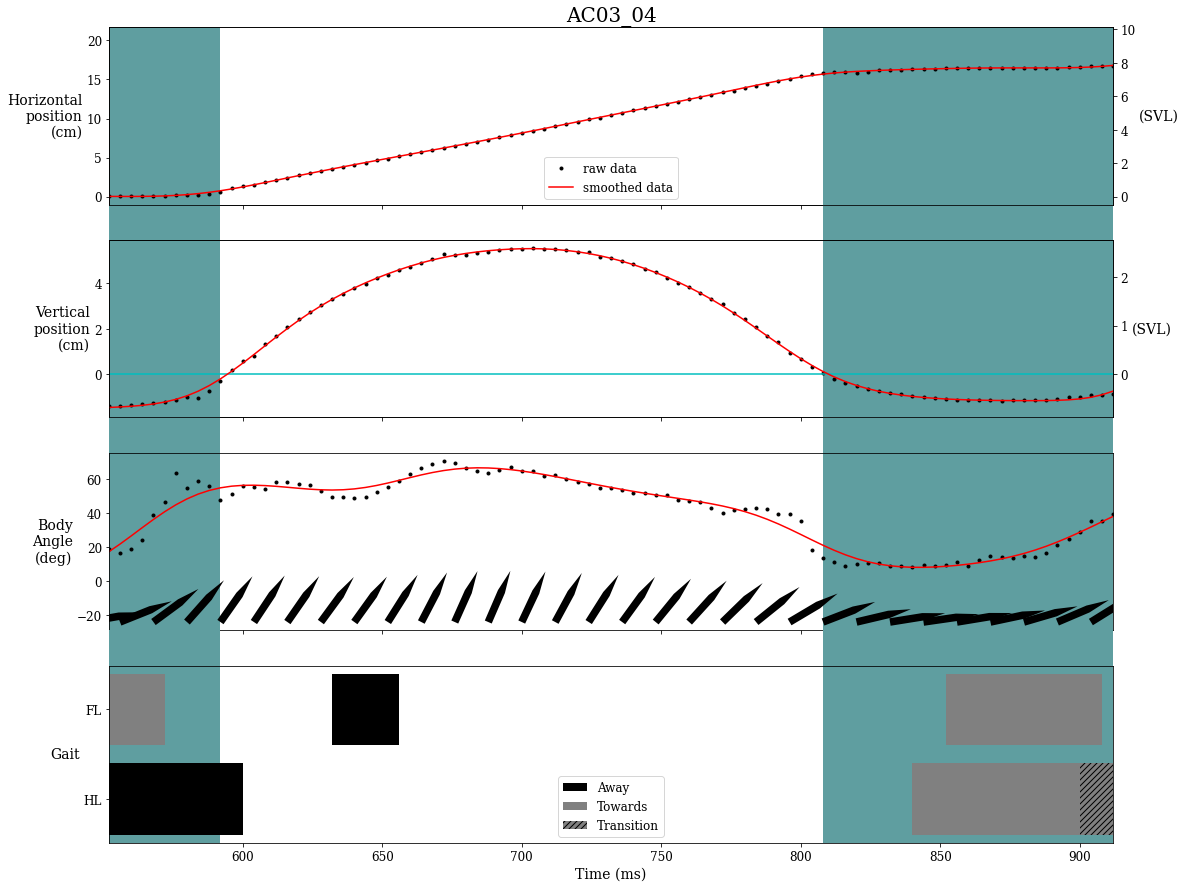

In [13]:

ax, fig = g.graph_all('AC03_04',  figsize=(18, 15), segment=True, clip=True)

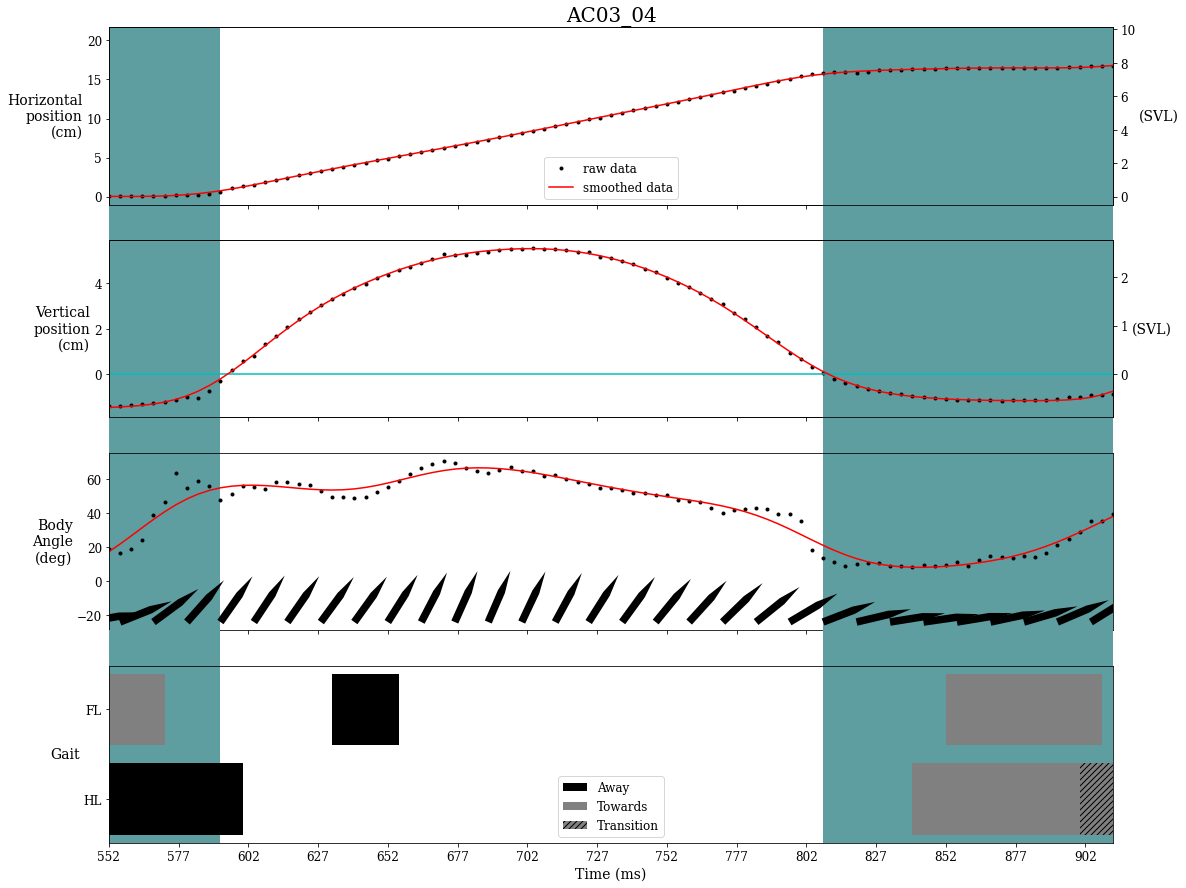

In [14]:
start, end = ax[3].get_xlim()
ax[3].set_xticks(np.arange(start, end, 25))
fig

In [8]:
from matplotlib.ticker import MaxNLocator
test = ax[3].get_xticks()

#ax[3].xaxis.set_major_formatter(MaxNLocator(integer=True))
ax[3].set_xticklabels(test - test[0])
fig

NameError: name 'ax' is not defined

In [16]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig.savefig('Figures/AC03_04_clipped.pdf', transparent=True)

/tmp/ipykernel_9259/353958162.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(test - test[0])
/tmp/ipykernel_9259/353958162.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(test - test[0])
/tmp/ipykernel_9259/353958162.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(test - test[0])
/tmp/ipykernel_9259/353958162.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(test - test[0])
/tmp/ipykernel_9259/353958162.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(test - test[0])
/tmp/ipykernel_9259/353958162.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(test - test[0])
/tmp/ipykernel_9259/353958162.py:19: UserWarning: FixedFormatter should only be used tog

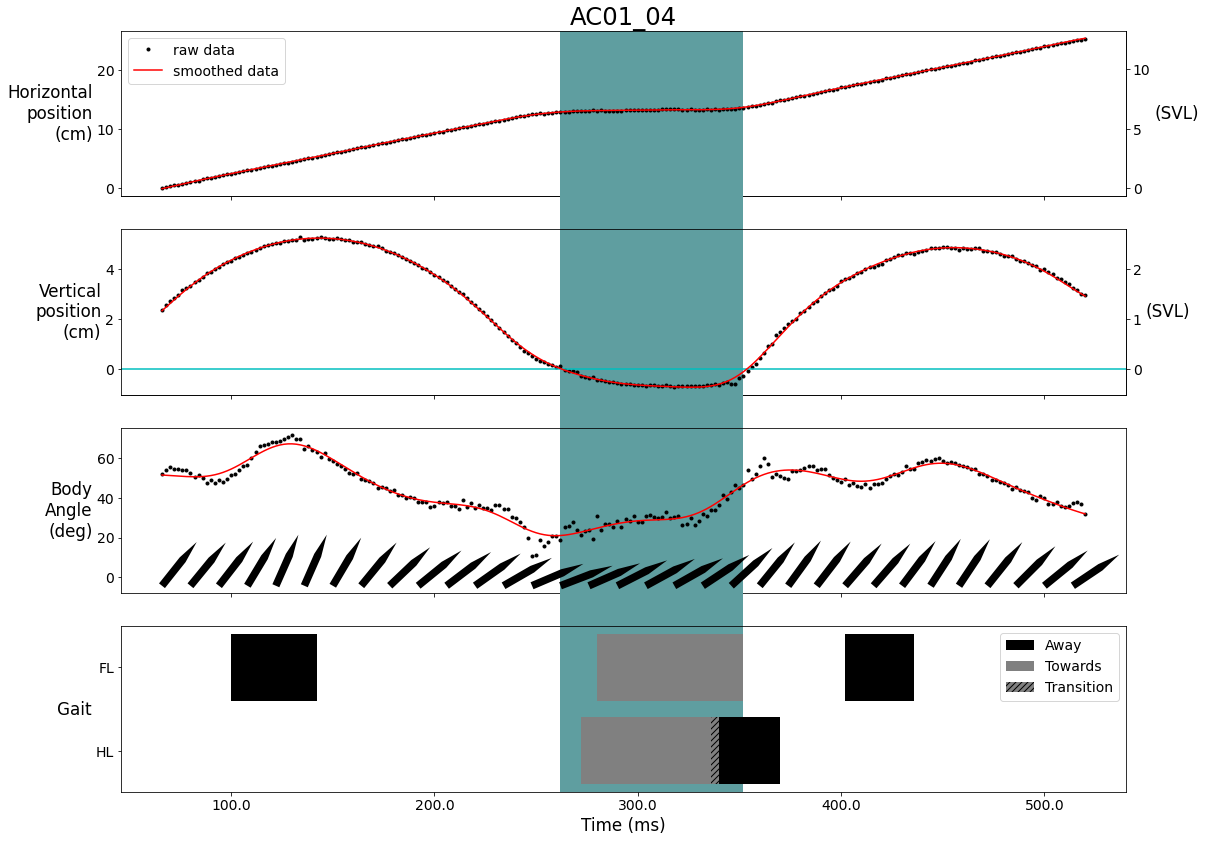

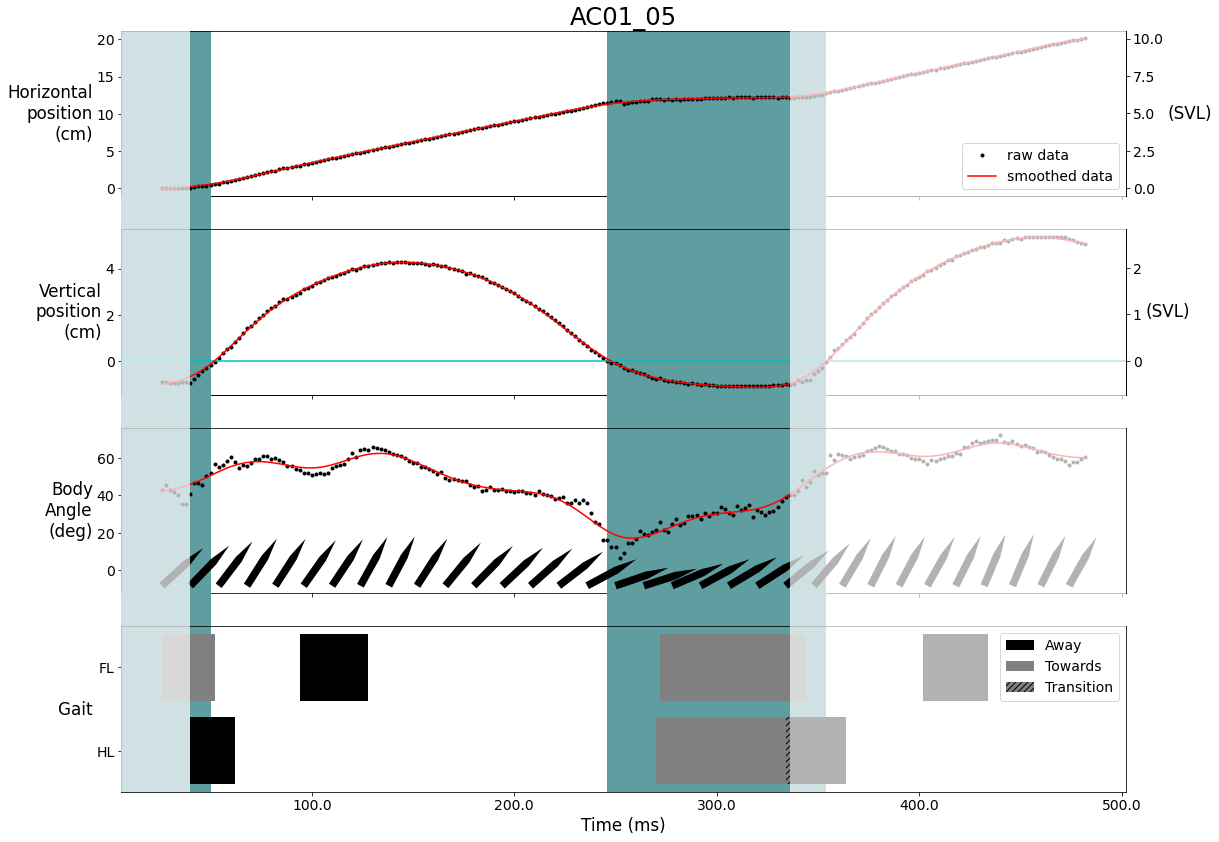

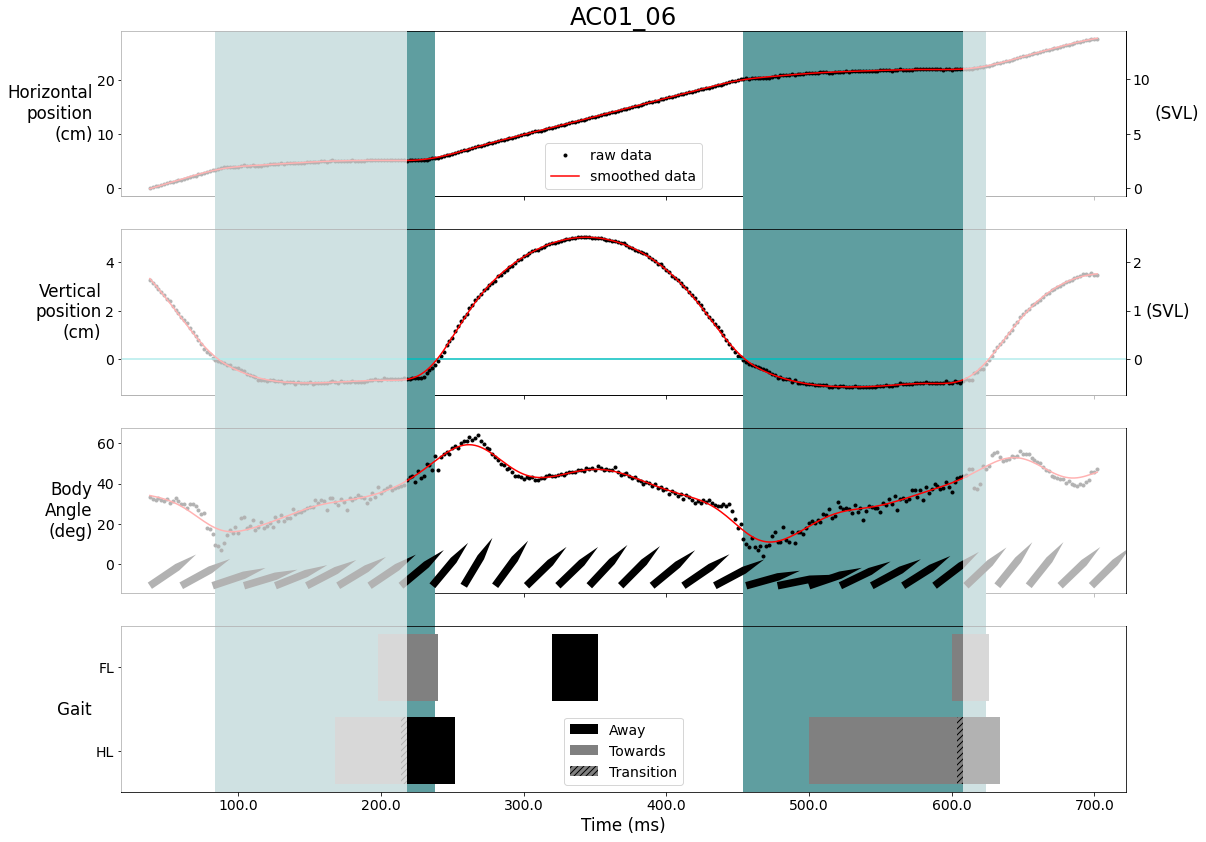

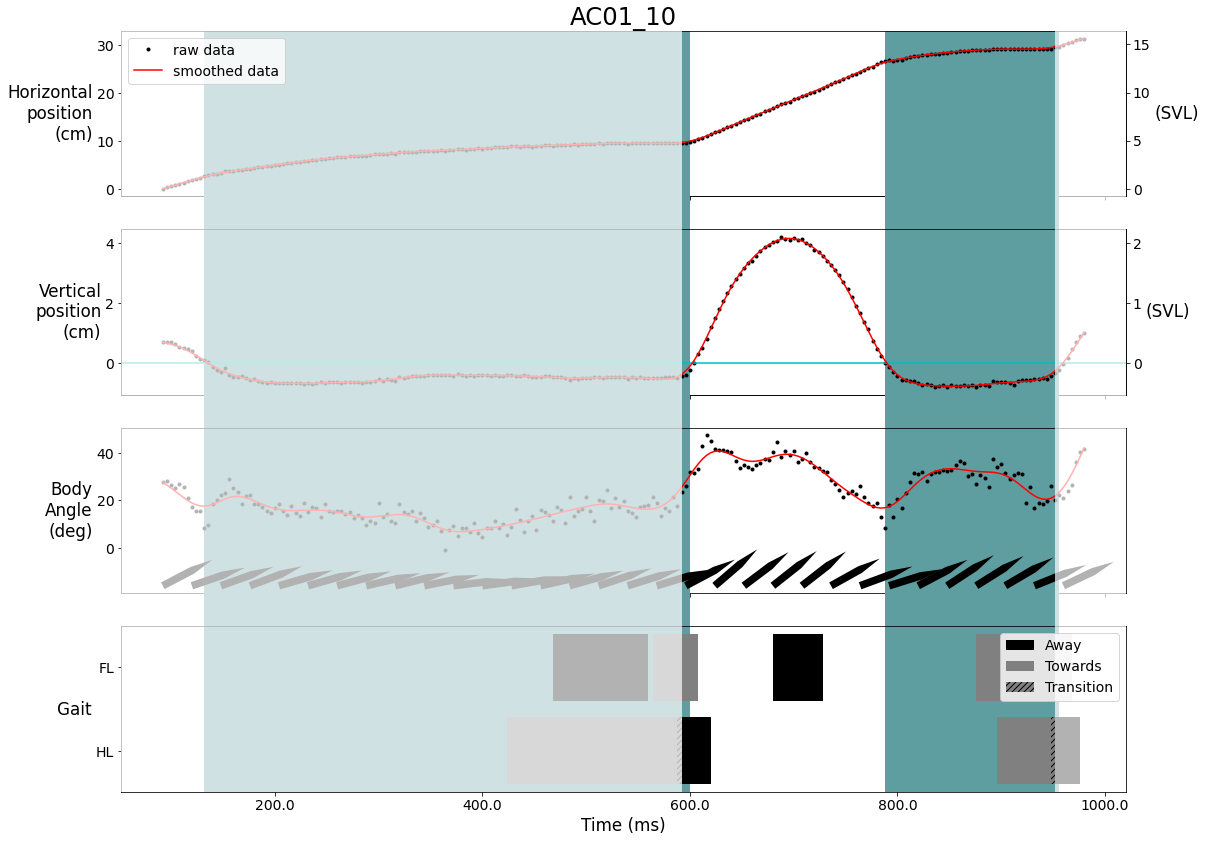

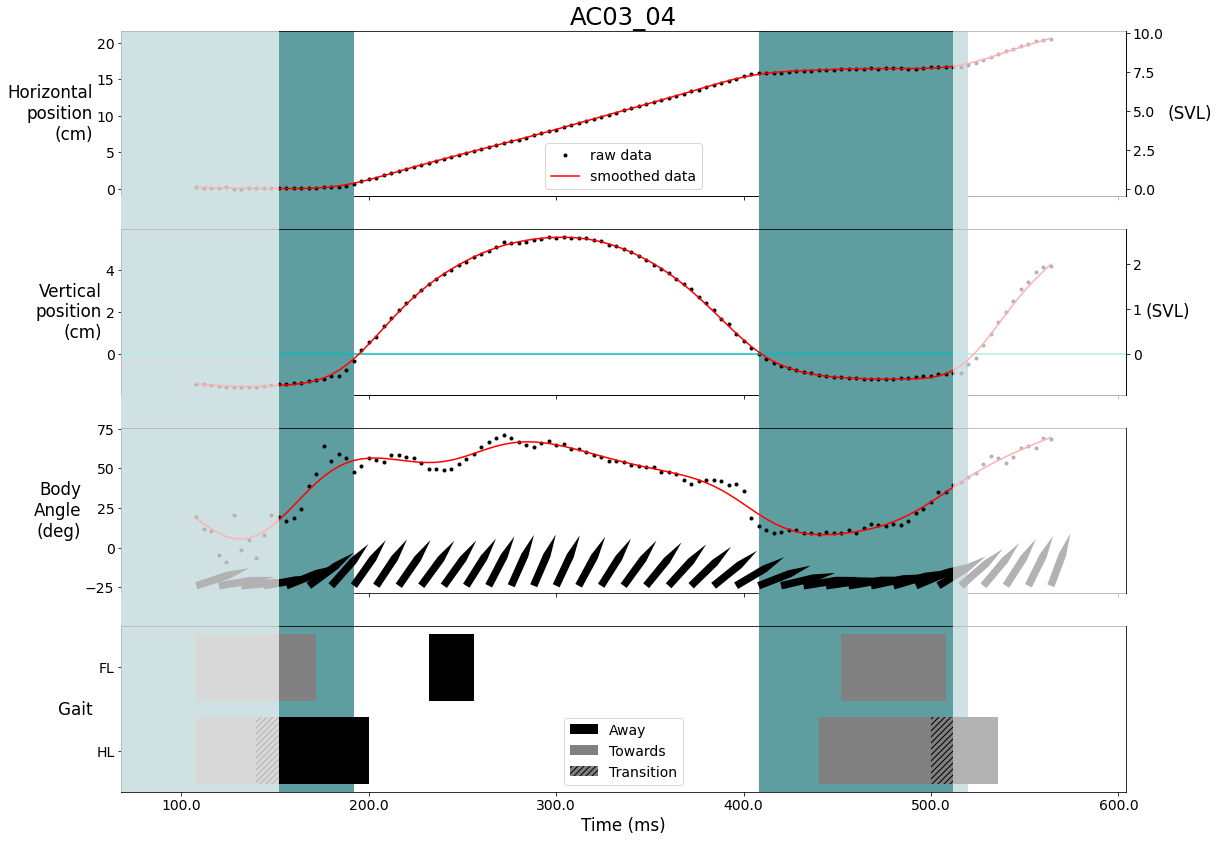

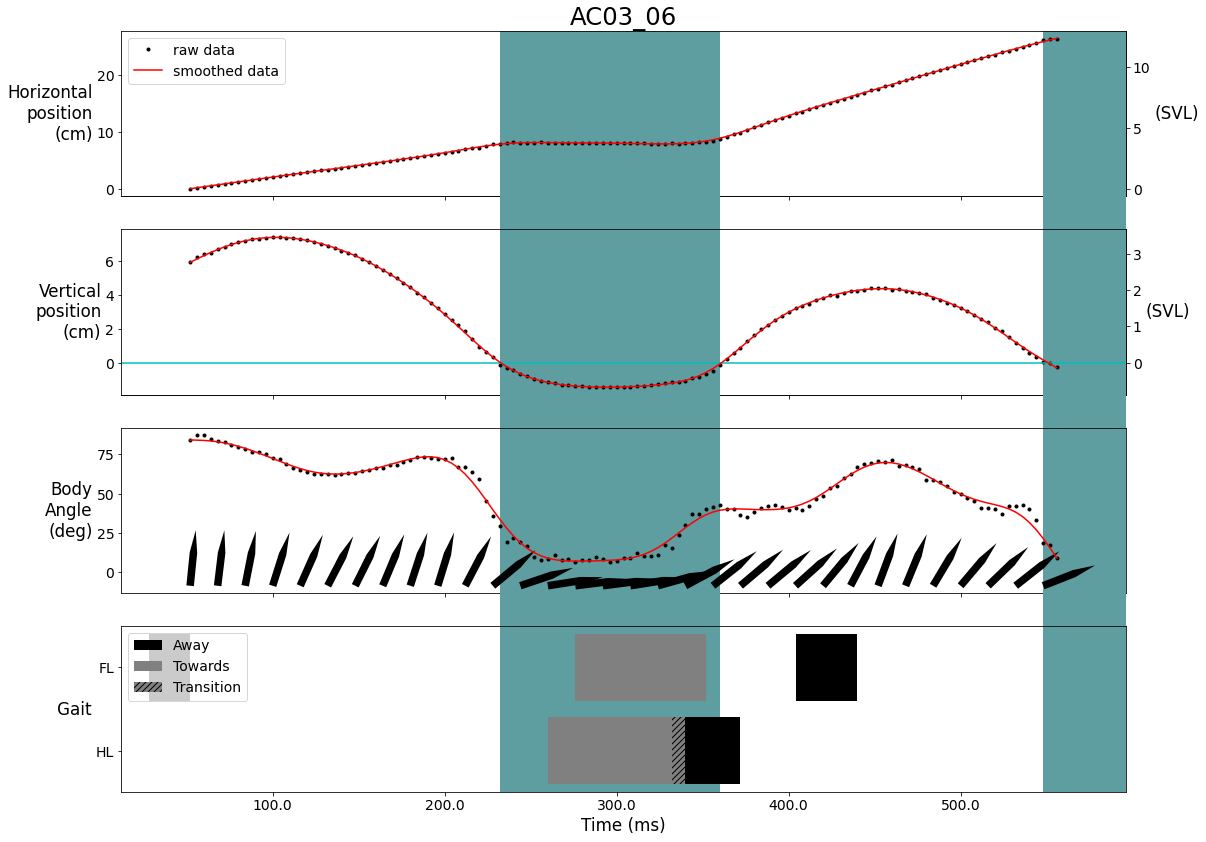

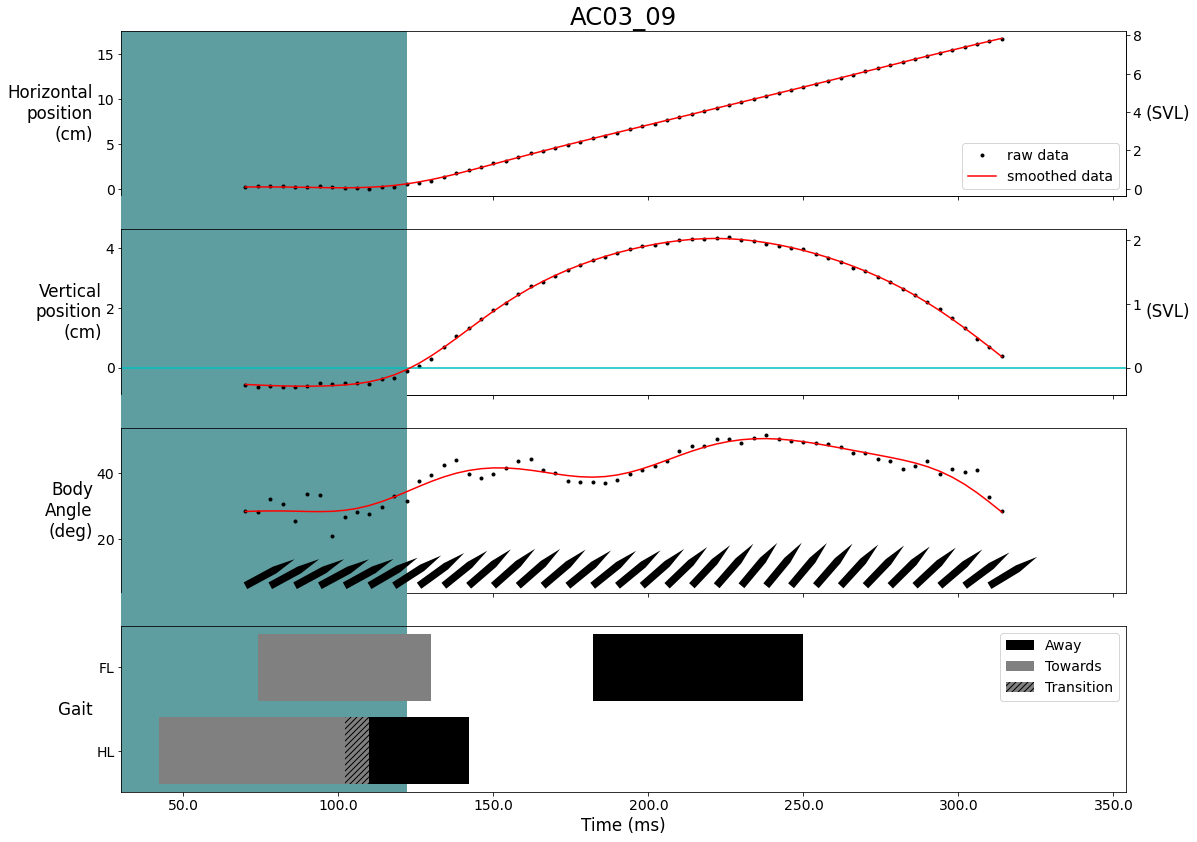

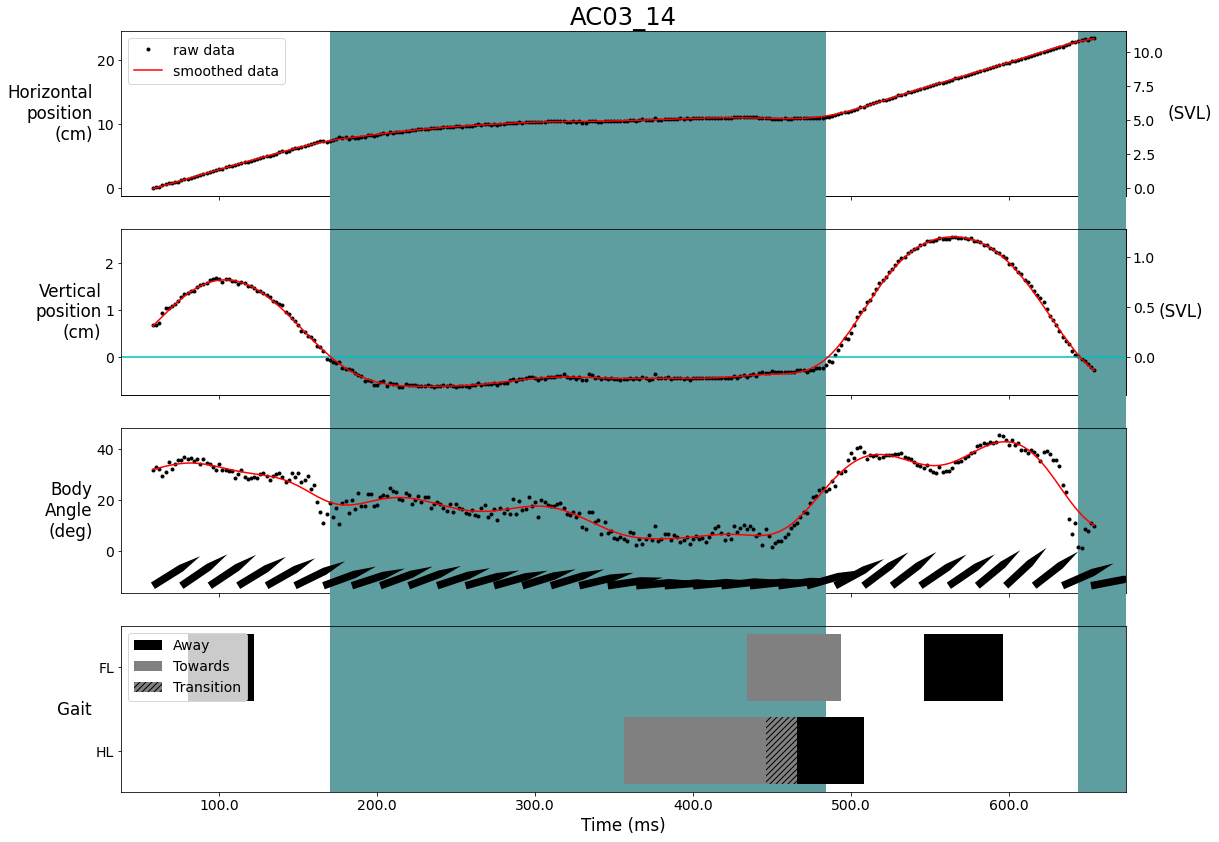

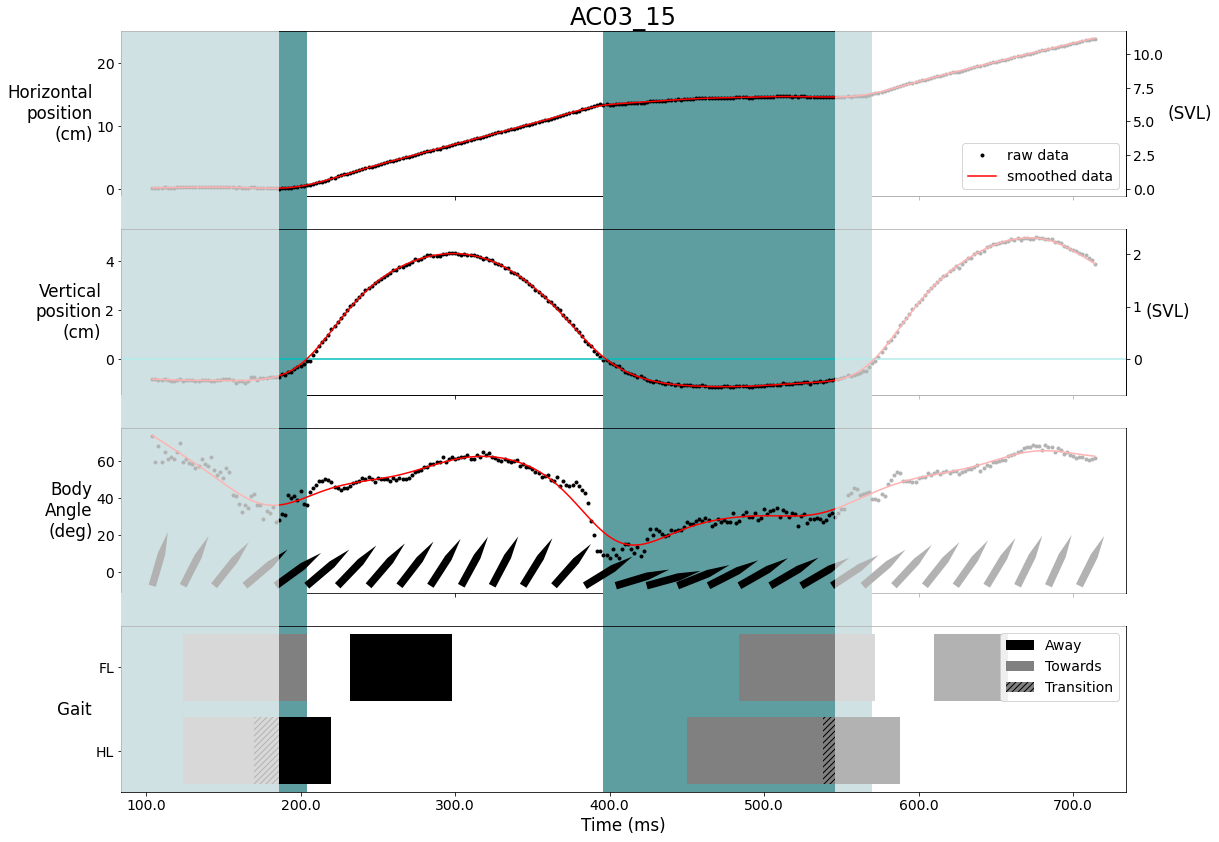

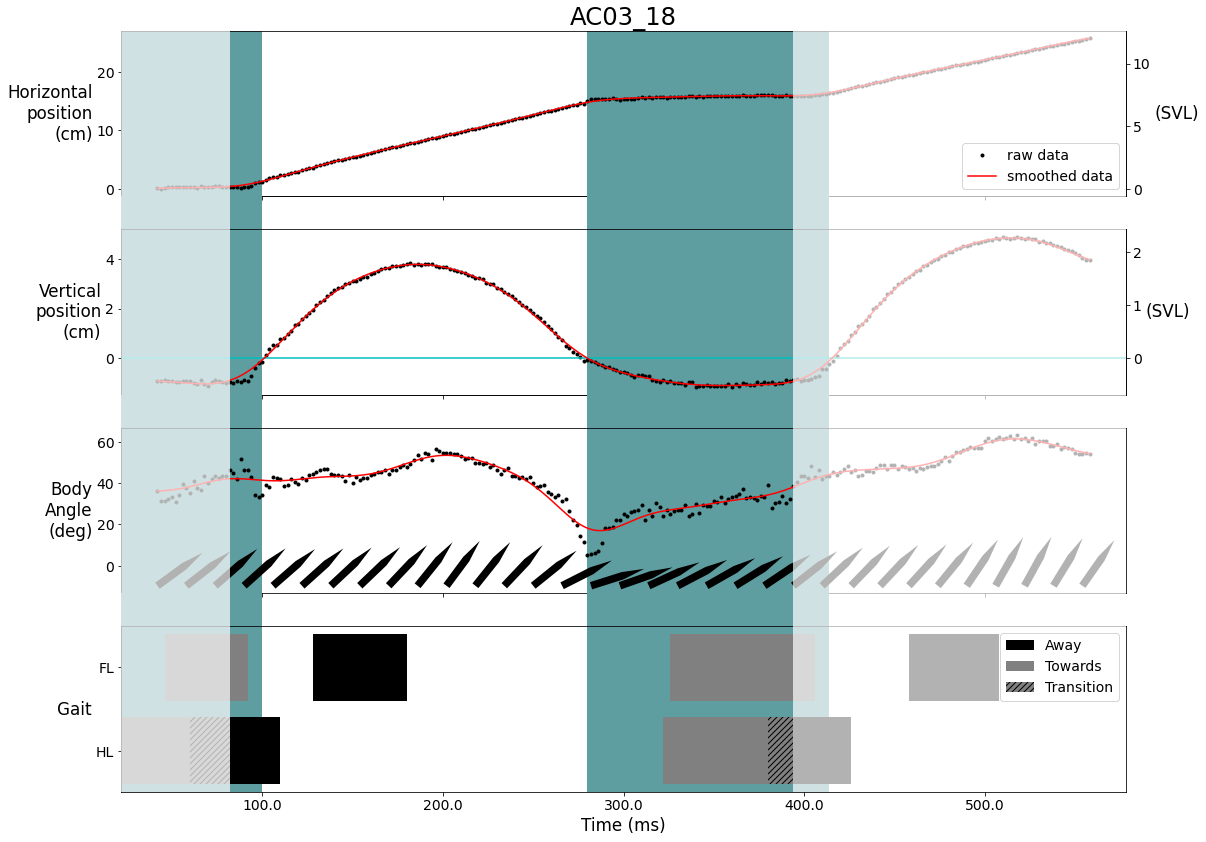

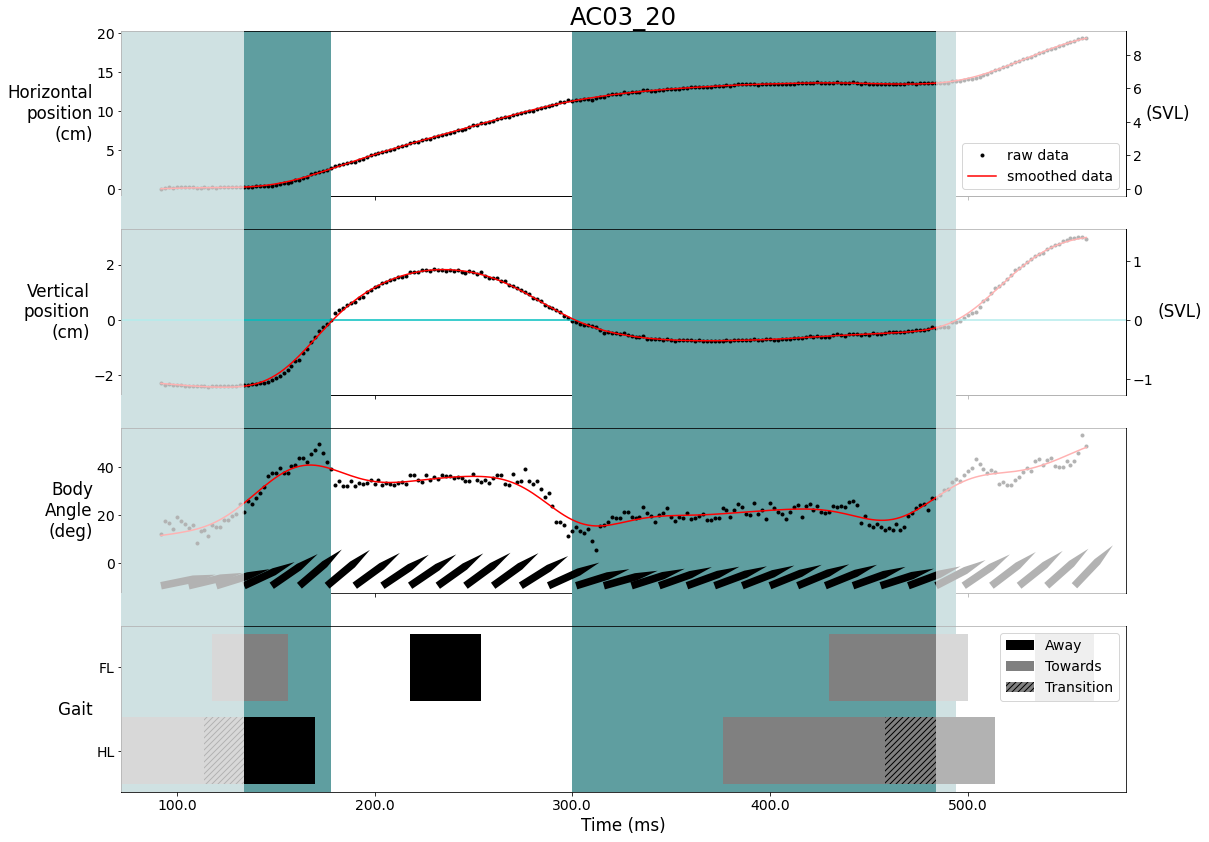

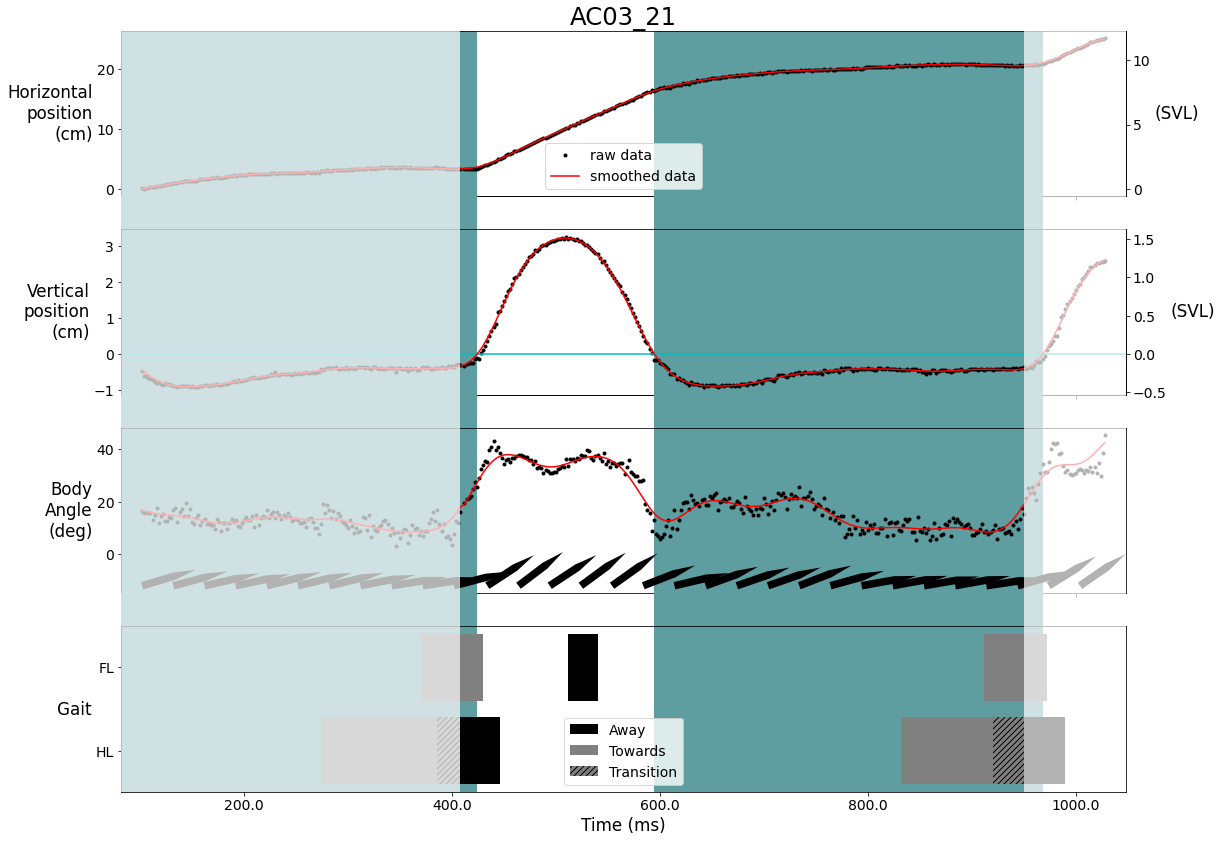

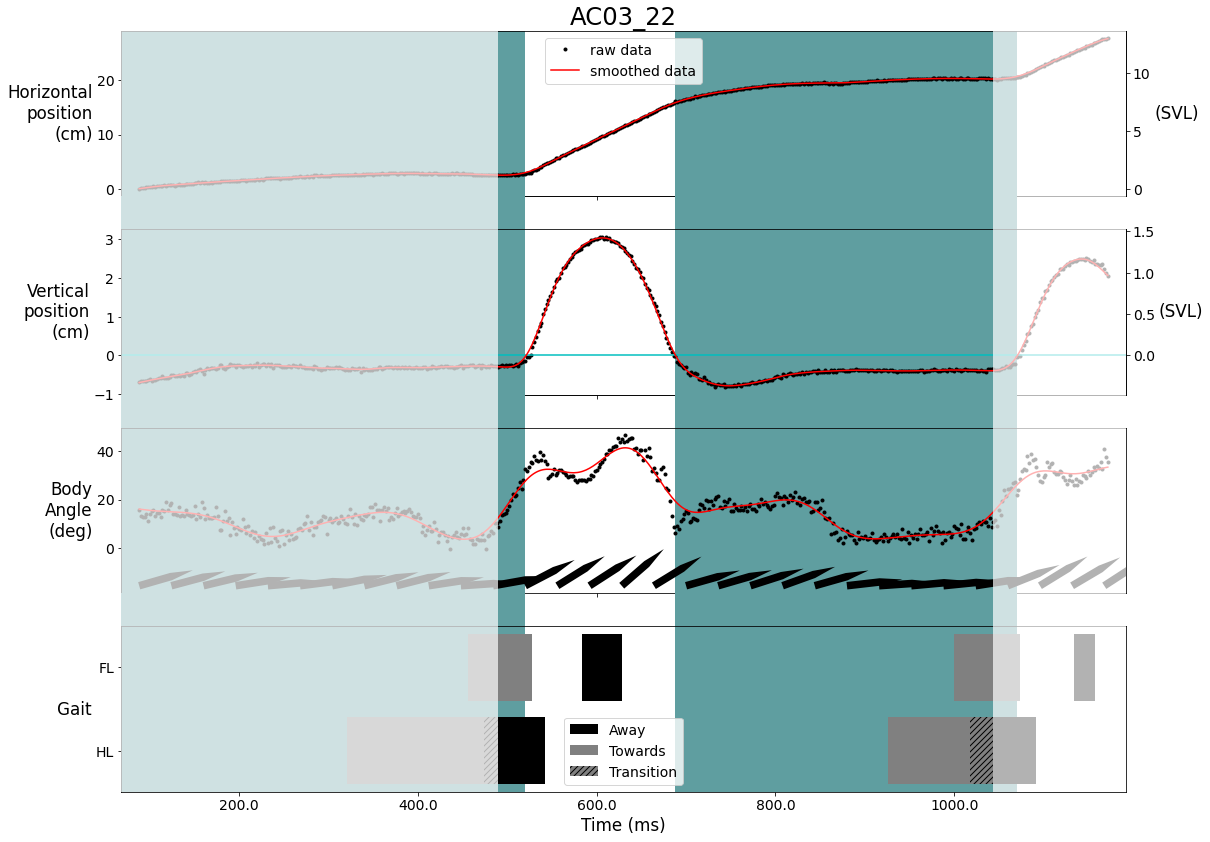

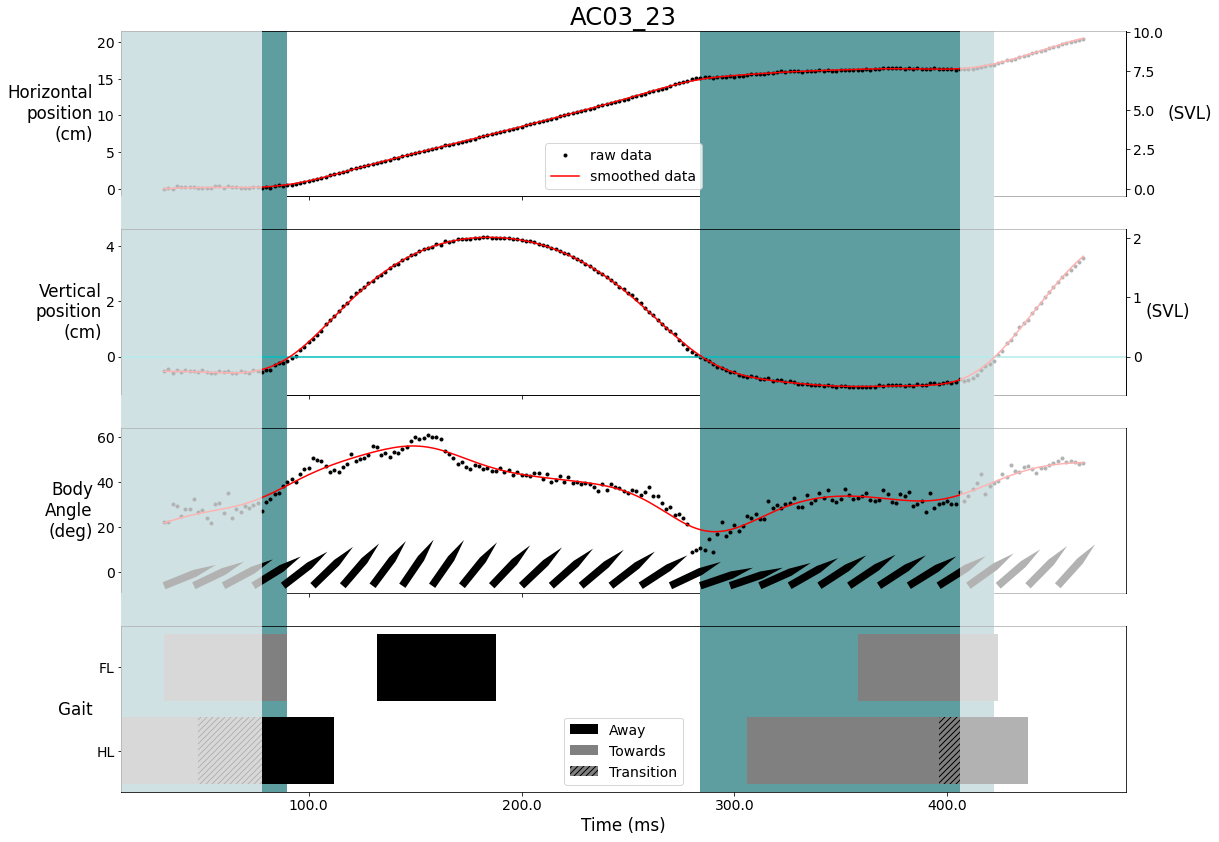

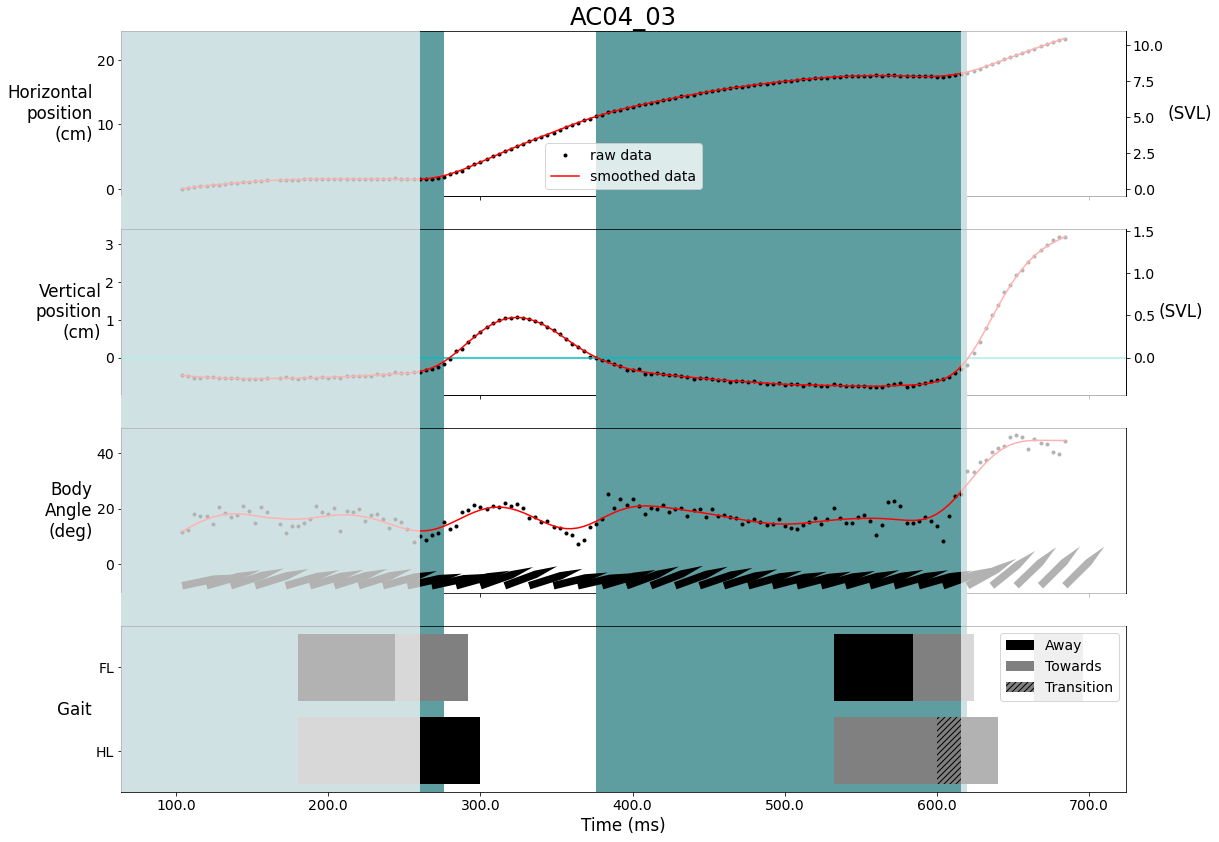

In [29]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Myriad Pro"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['axes.titlesize'] = 'xx-large'
matplotlib.rcParams['axes.labelsize'] = 'large'
matplotlib.rcParams['figure.titlesize'] = 'xx-large'
matplotlib.rcParams['xtick.labelsize'] = 'medium'
matplotlib.rcParams['ytick.labelsize'] = 'medium'
matplotlib.rcParams['legend.fontsize'] = 'medium'
for frog in full_list_seq:
    if frog in get_list_strict_jump_cyc():
        ax, fig = g.graph_all(frog,  figsize=(18, 14), segment=True, clip=False)
    else:
        ax, fig = g.graph_all(frog,  figsize=(18, 14), segment=False, clip=False)
    test = ax[3].get_xticks()

    #ax[3].xaxis.set_major_formatter(MaxNLocator(integer=True))
    ax[3].set_xticklabels(test - test[0])
    for axs in ax:
        axs.set_zorder(500)
    fig.savefig(f'Figures/All_kinematics/{frog}_position.pdf', transparent=True)

/tmp/ipykernel_9259/4193332081.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(test - test[0])
/tmp/ipykernel_9259/4193332081.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(test - test[0])
/tmp/ipykernel_9259/4193332081.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(test - test[0])
/tmp/ipykernel_9259/4193332081.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(test - test[0])
/tmp/ipykernel_9259/4193332081.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(test - test[0])
/tmp/ipykernel_9259/4193332081.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(test - test[0])
/tmp/ipykernel_9259/4193332081.py:9: UserWarning: FixedFormatter should only be used tog

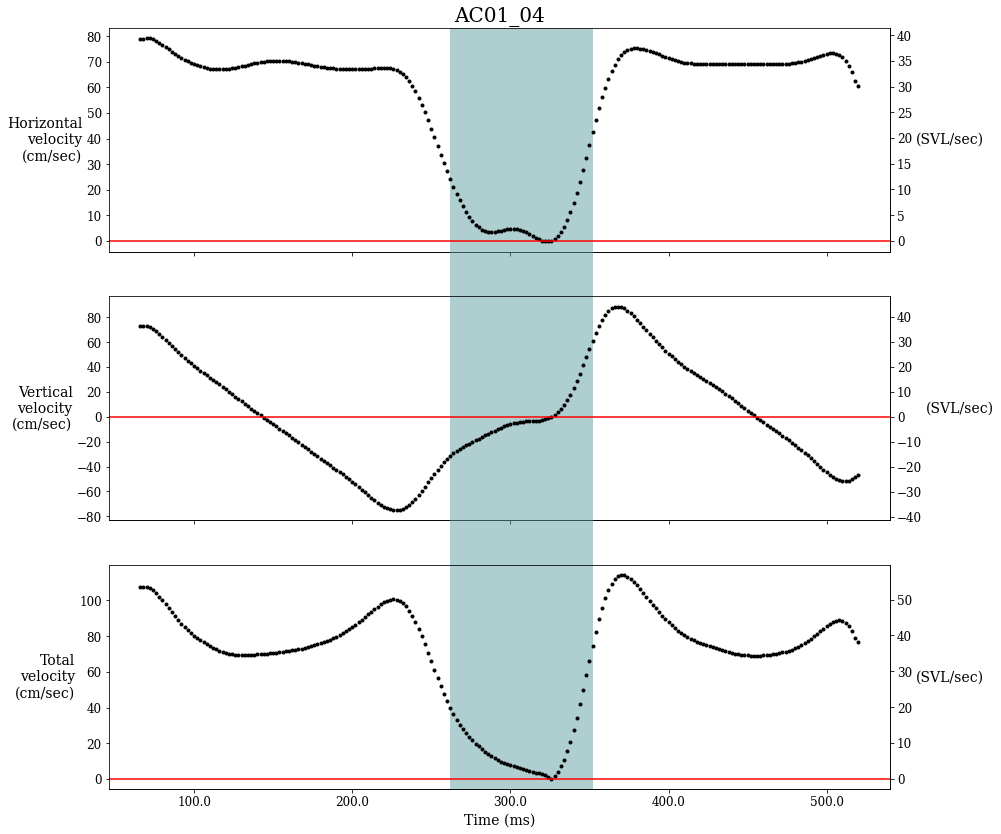

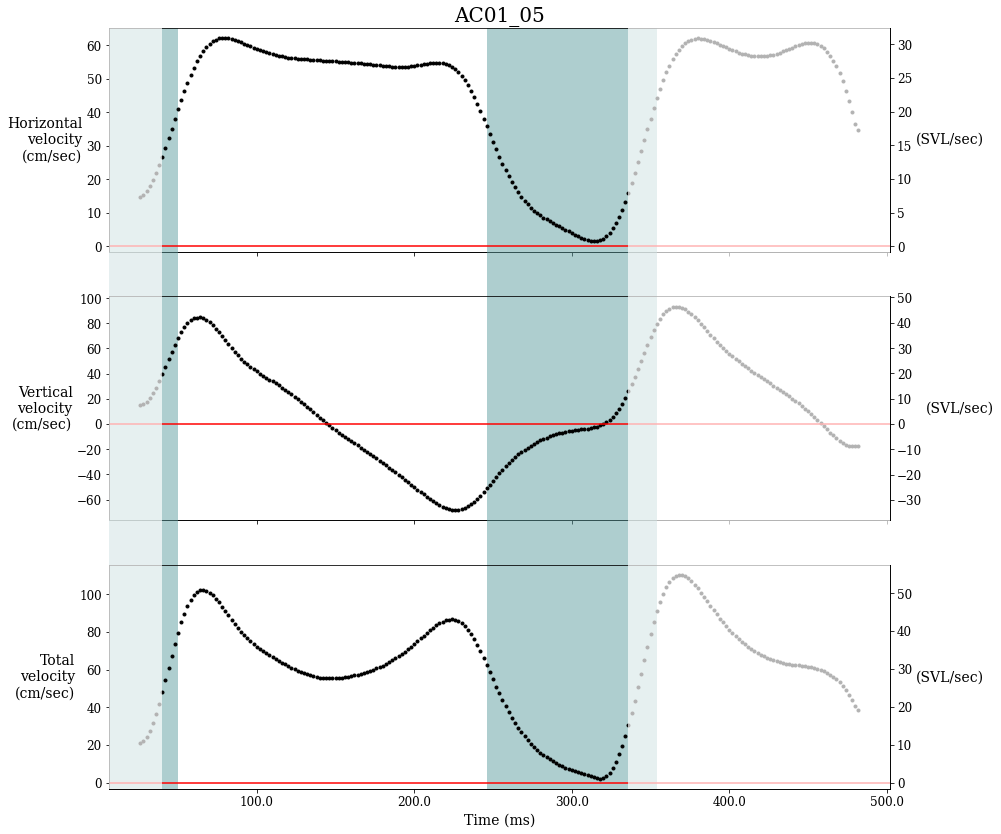

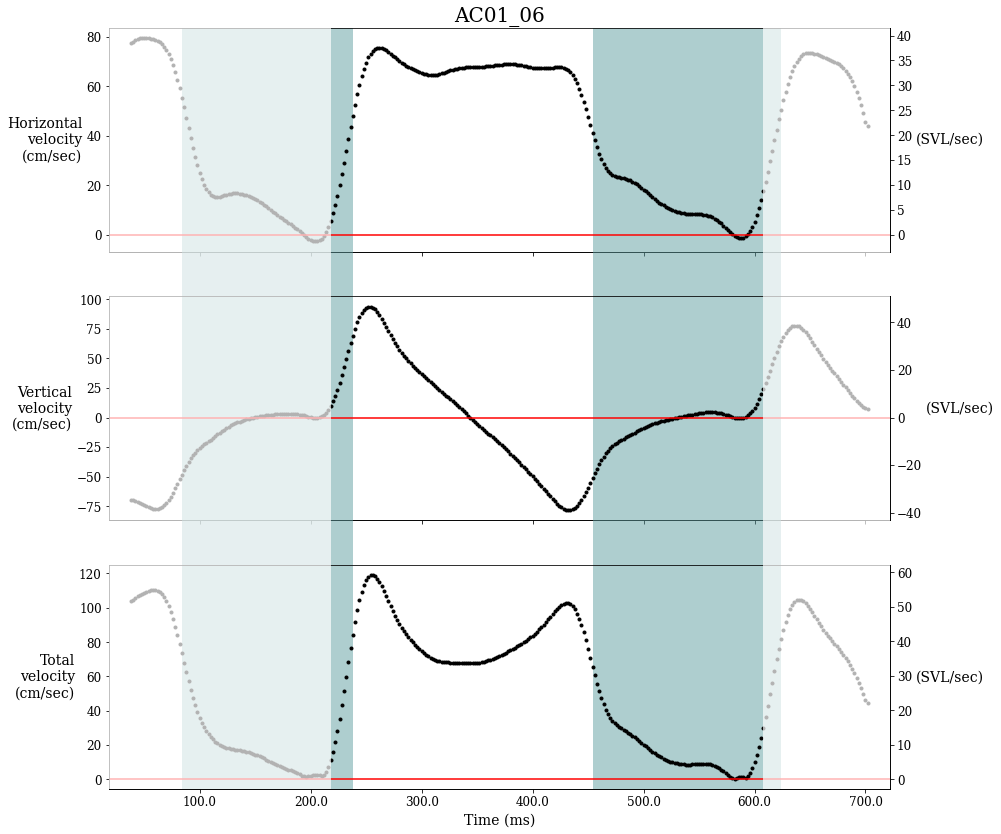

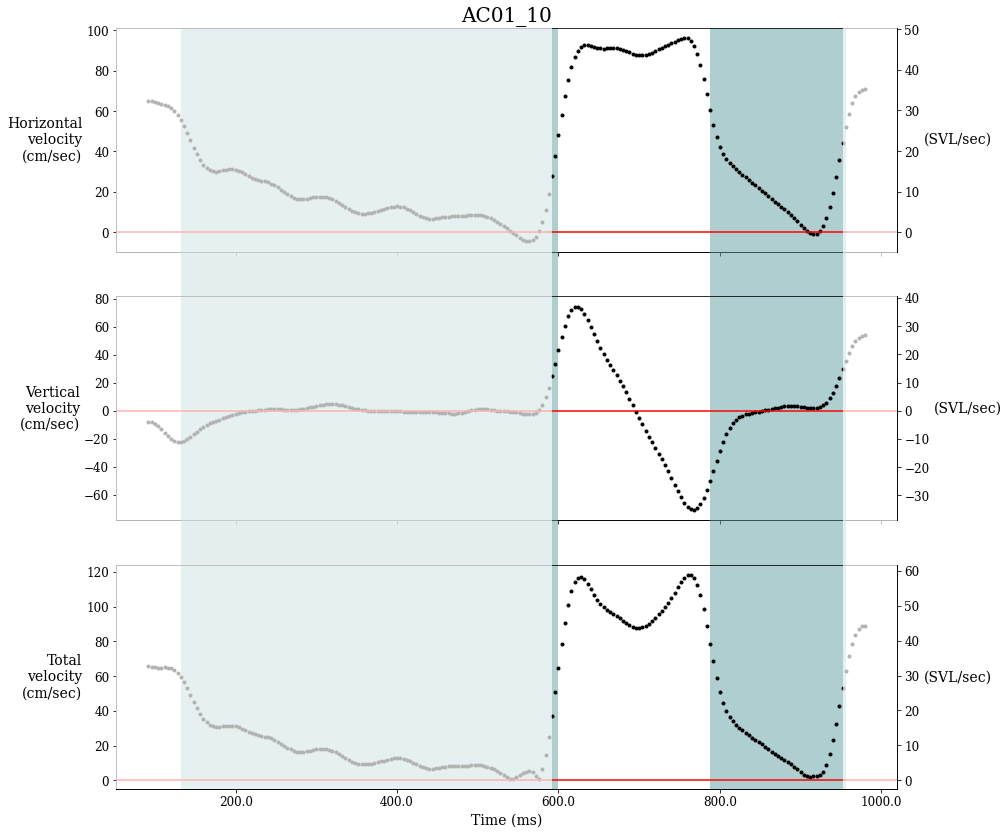

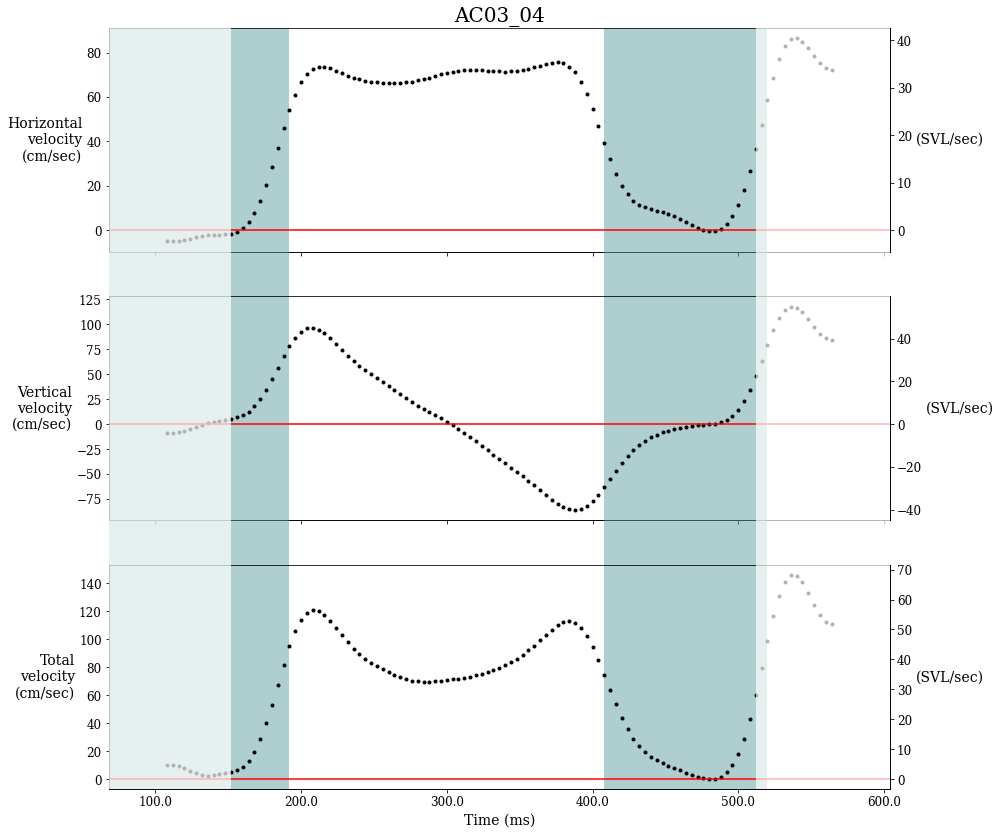

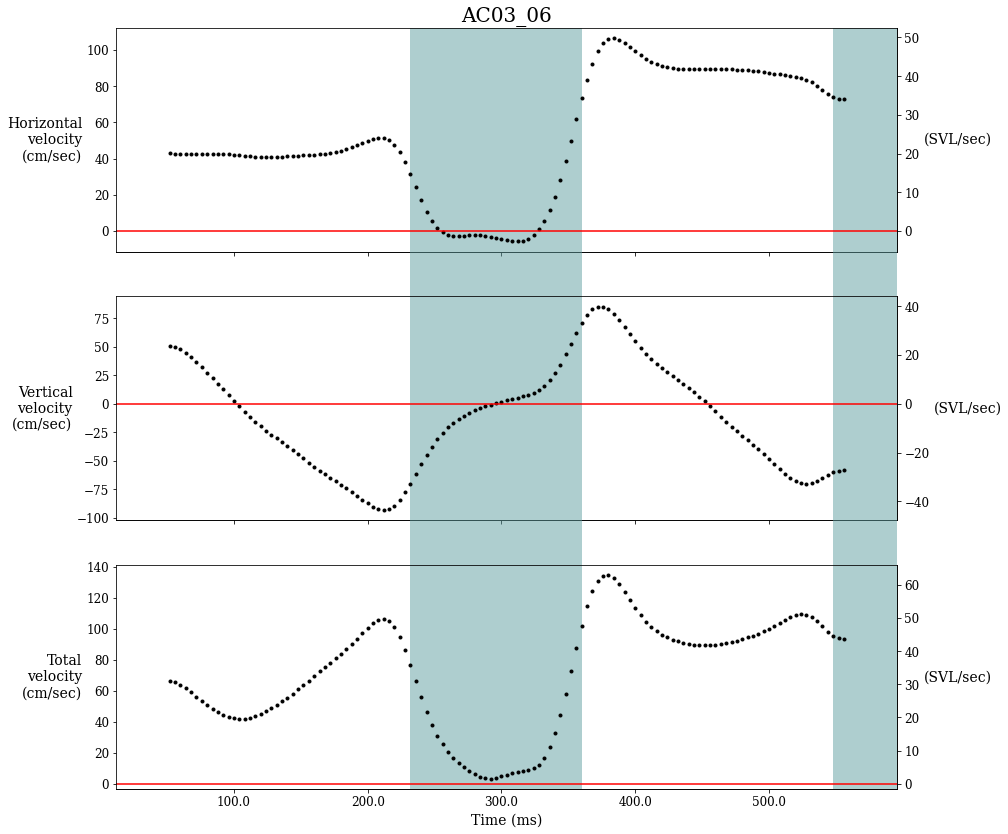

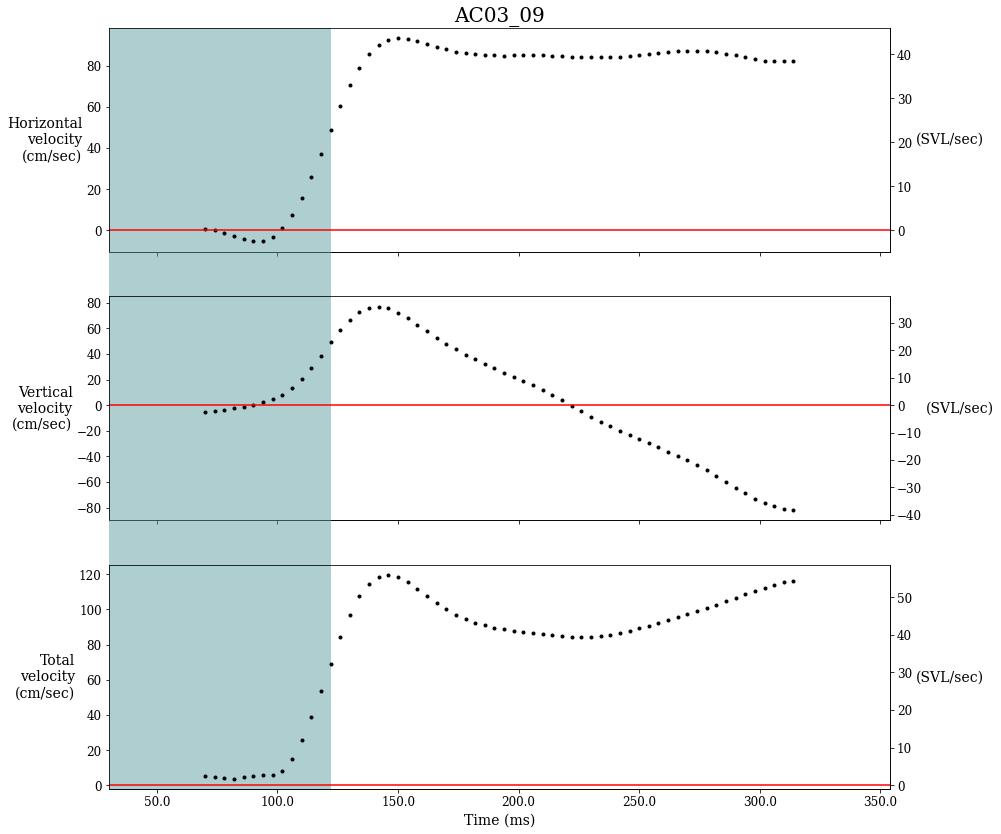

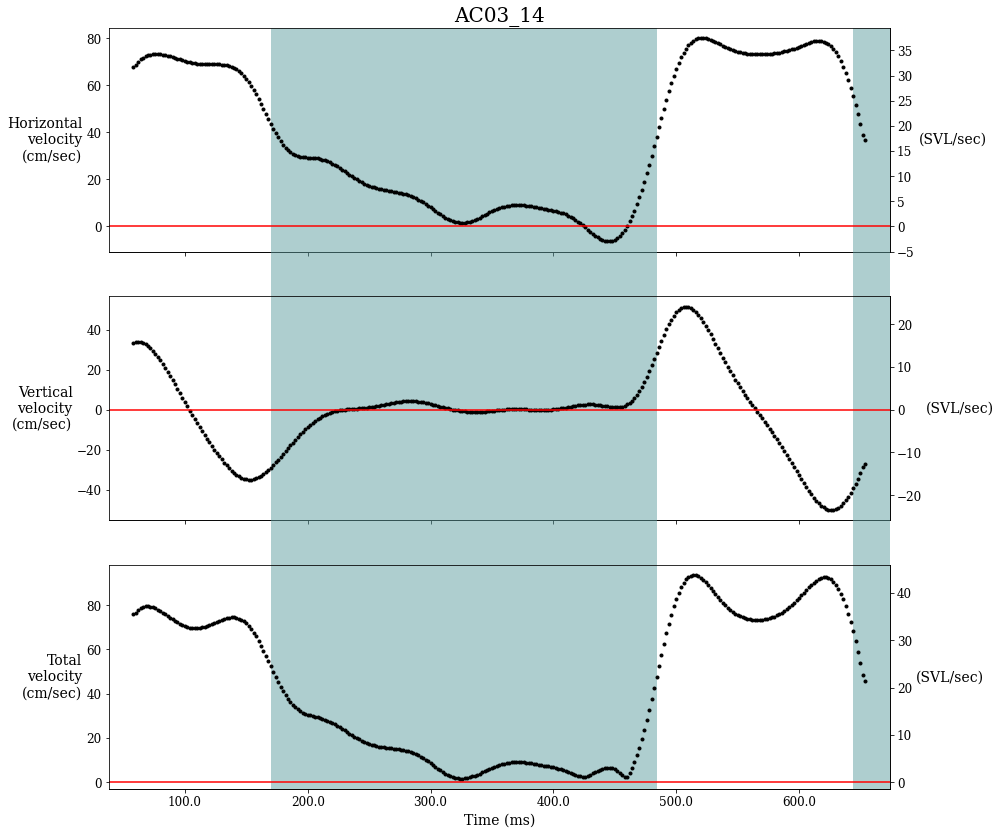

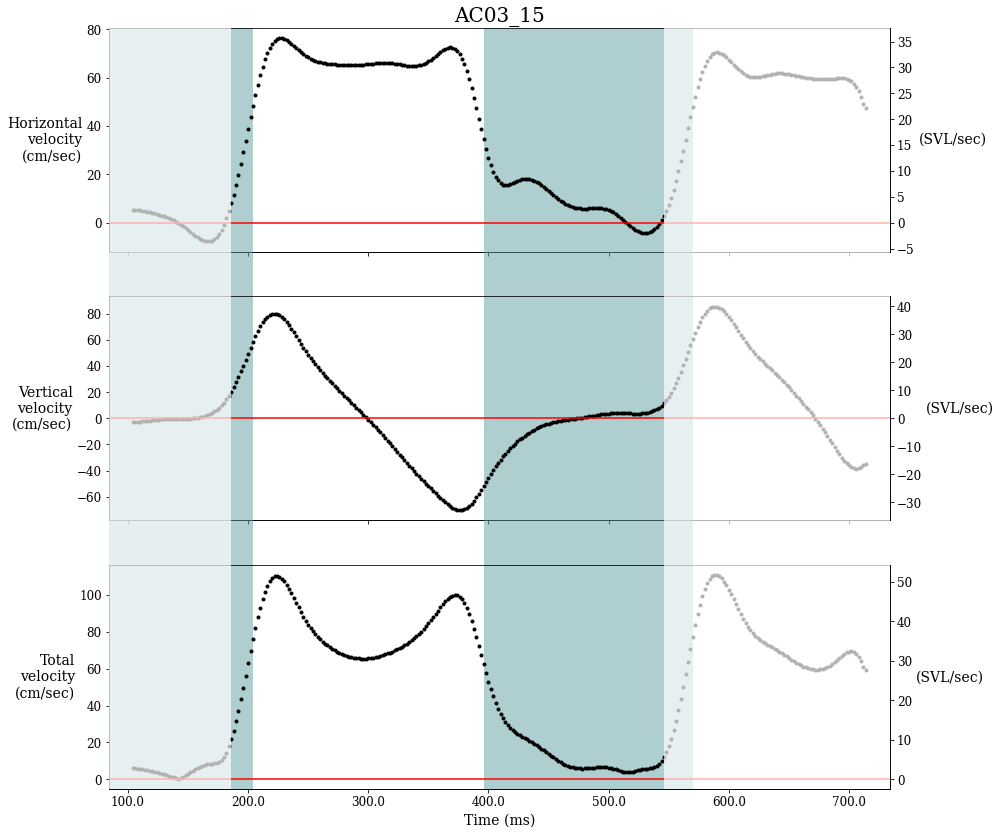

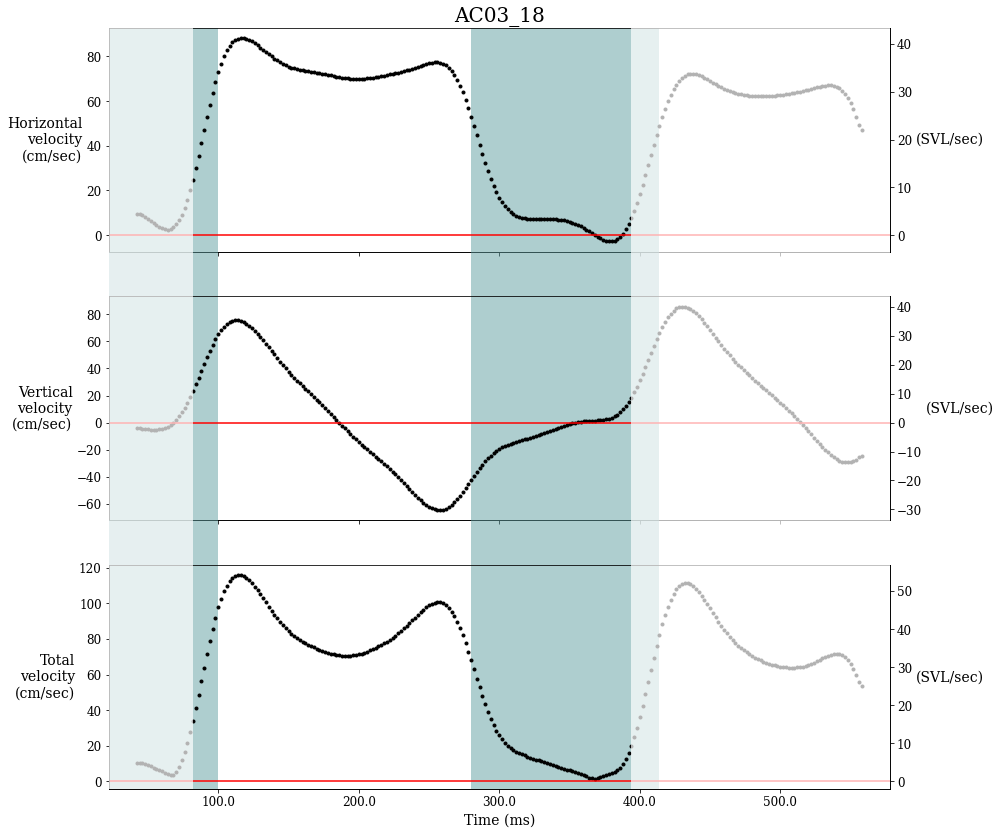

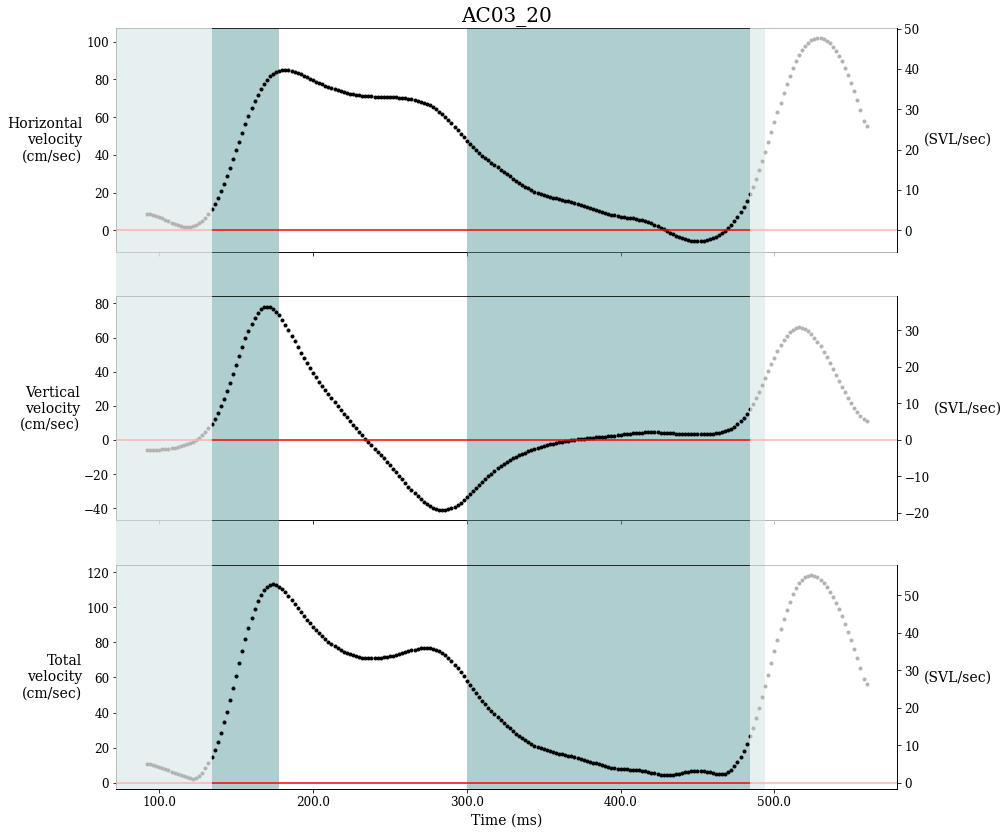

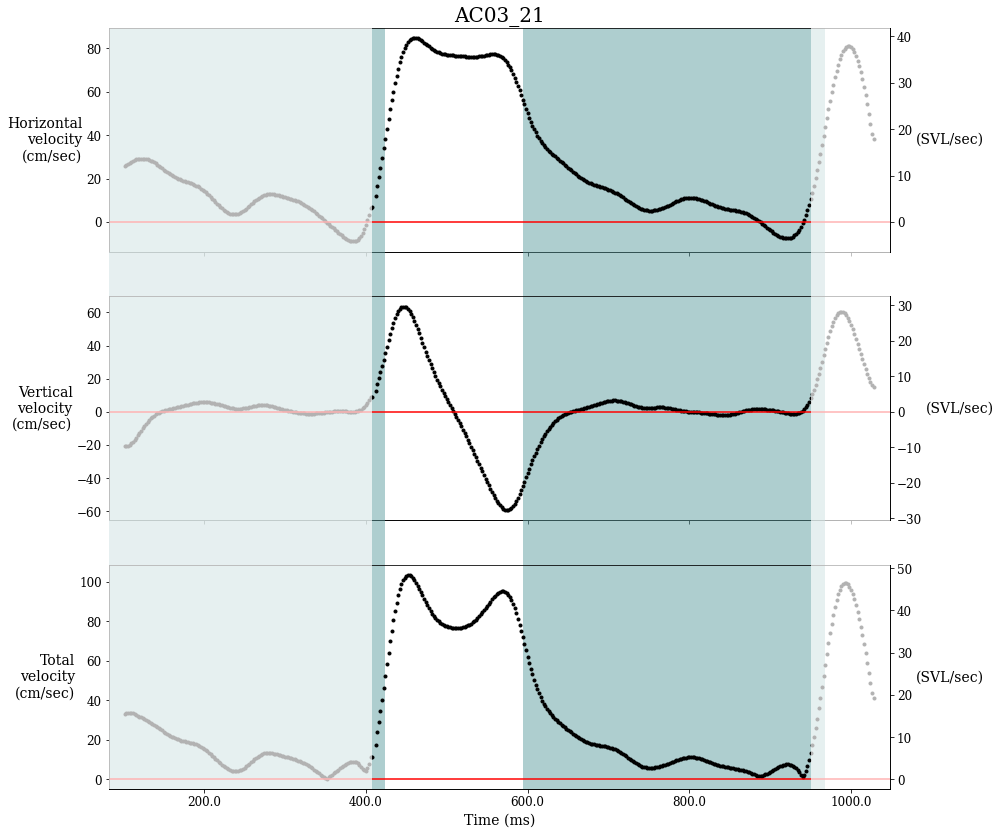

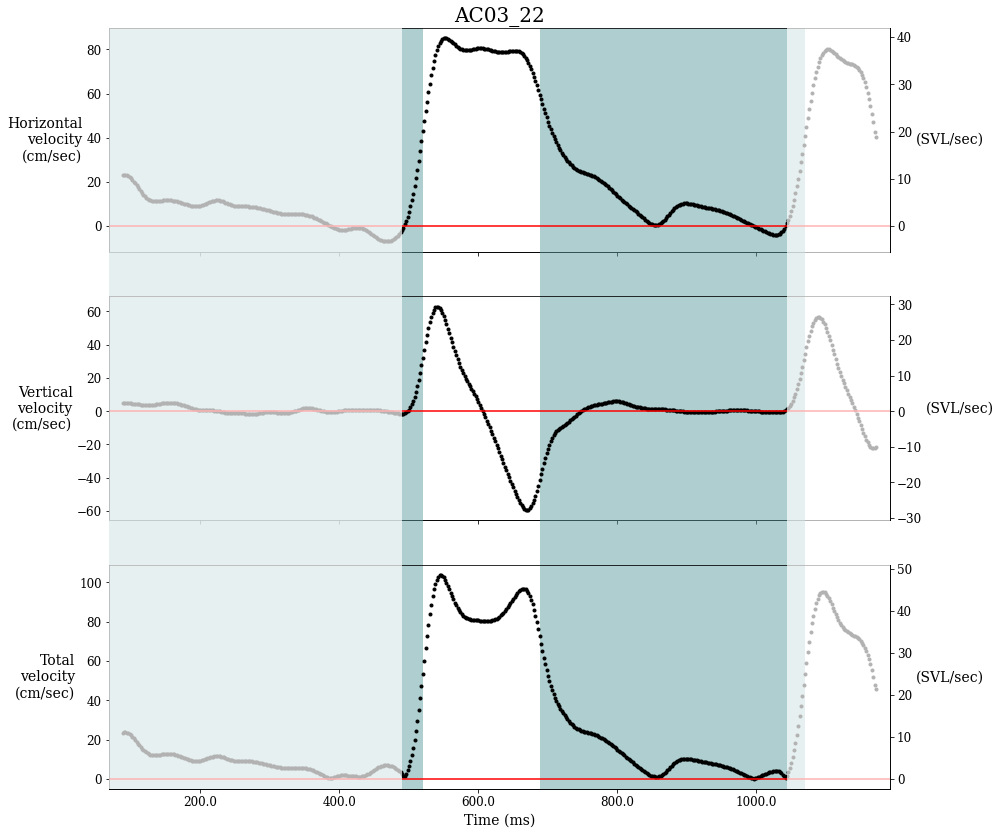

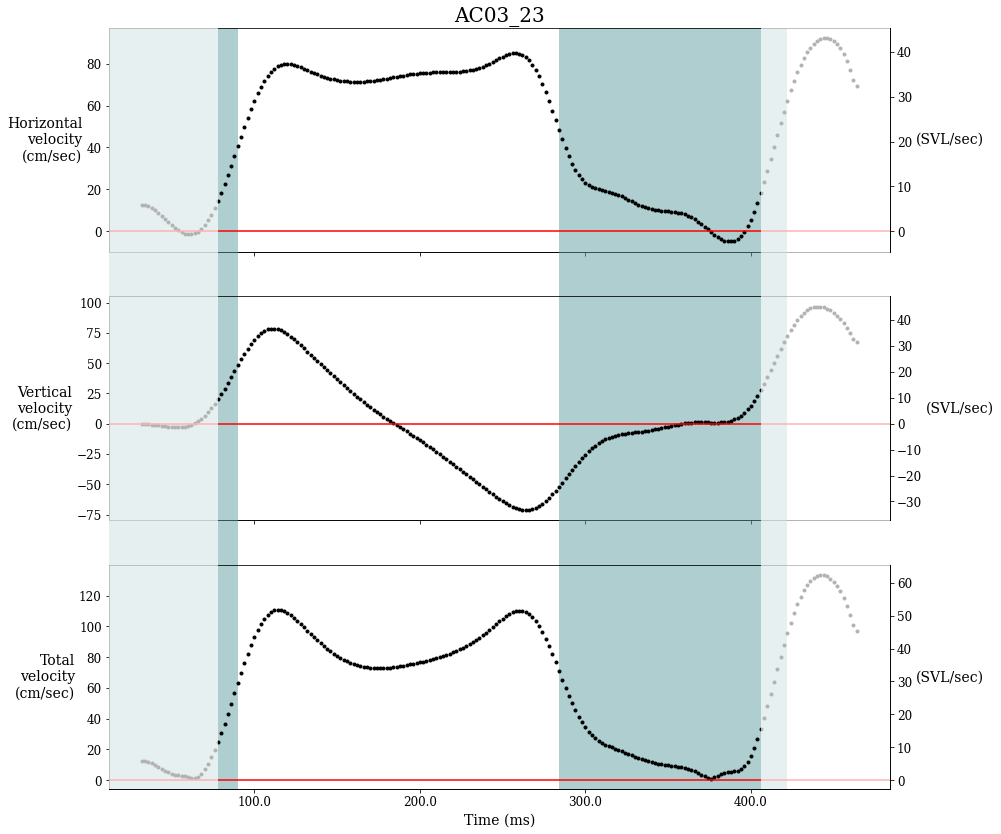

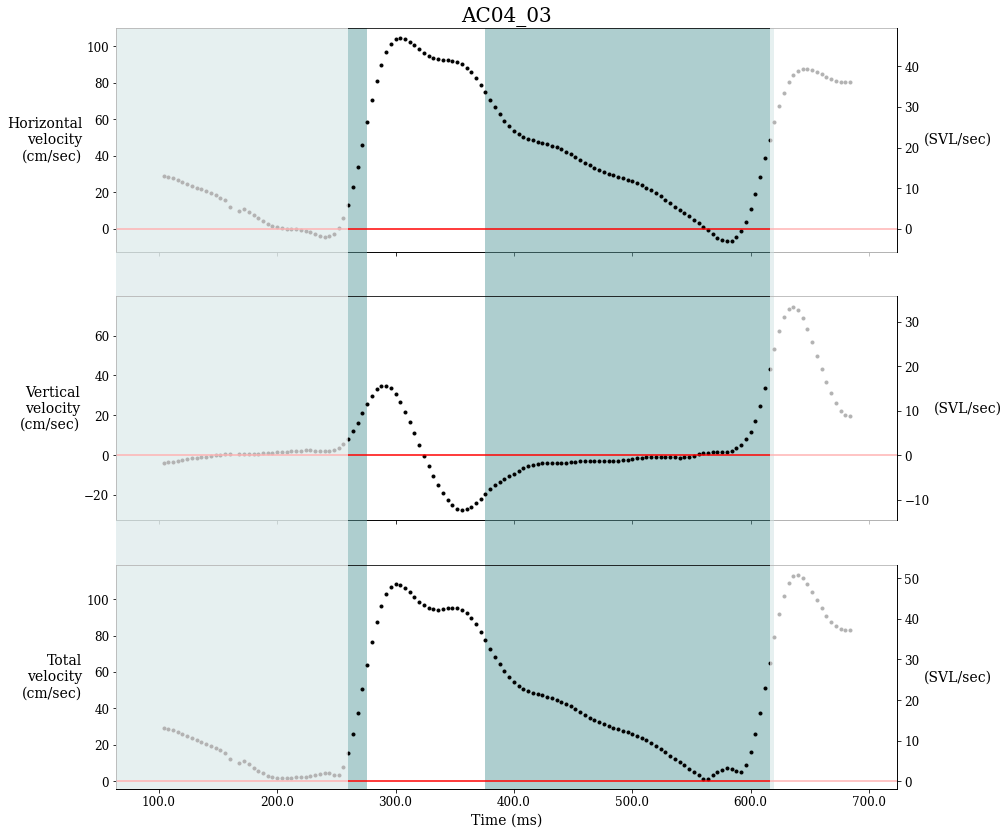

In [41]:
for frog in full_list_seq:
    if frog in get_list_strict_jump_cyc():
        ax, fig = g.graph_vel(frog,  figsize=(14, 14), segment=True, clip=False)
    else:
        ax, fig = g.graph_vel(frog,  figsize=(14, 14), segment=False, clip=False)
    test = ax[2].get_xticks()

    #ax[3].xaxis.set_major_formatter(MaxNLocator(integer=True))
    ax[2].set_xticklabels(test - test[0])
    for axs in ax:
        axs.set_zorder(500)
    fig.savefig(f'Figures/All_kinematics/{frog}_velocity.pdf', transparent=True)

# Something Else

In [50]:
a = pd.read_excel('../210709_Talia_CricketFrog_forANOVA.xlsx', sheet_name='SkitteringTerrestrialRAW', na_values=' ')

In [51]:
a.columns

Index(['ID', 'JumpNo', 'frog', 'Type', 'SVL(cm)', 'fps', 'px/SVL',
       'frameWaterExit', 'frameWaterLand', 'frameDurationAboveWater',
       'secDurationAboveWater', 'AboveWaterActualHeight_px',
       'AboveWaterActualHeight_cm', 'AboveWaterActualRange_px',
       'AboveWaterActualRange_cm', 'AboveWaterFitHeight_px',
       'AboveWaterFitHeight_cm', 'AboveWaterFitRange_px',
       'AboveWaterFitRange_cm', 'BAatWC_launch', 'BAatWC_land',
       'framePropStart', 'frameDurationProp', 'secDurationProp',
       'framePrepStart', 'frameDurationPrep', 'secDurationPrep',
       'frameDurationWait', 'secDurationWait', 'BelowWaterRange_before_px',
       'BelowWaterRange_before_cm', 'BelowWaterRange_after_px',
       'BelowWaterRange_after_cm', 'MaxHeightBelowWater_before_px',
       'MaxHeightBelowWater_before_cm', 'MaxHeightBelowWater_after_px',
       'MaxHeightBelowWater_after_cm', 'BelowWater_BA_PrepStart',
       'BelowWater_BA_PrepEnd', 'AVG_BelowWater_BA_before',
       'AVG_AboveWa

In [52]:
a['real_height_cm'] = pd.concat([a['AboveWaterActualHeight_cm'],a['MaxHeightBelowWater_before_cm']], 1).sum(1)
a['real_range_cm'] =  pd.concat([a['AboveWaterActualRange_cm'], a['BelowWaterRange_after_cm'], a['BelowWaterRange_before_cm']], 1).sum(1)

/tmp/ipykernel_9259/1760096112.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  a['real_height_cm'] = pd.concat([a['AboveWaterActualHeight_cm'],a['MaxHeightBelowWater_before_cm']], 1).sum(1)
/tmp/ipykernel_9259/1760096112.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  a['real_range_cm'] =  pd.concat([a['AboveWaterActualRange_cm'], a['BelowWaterRange_after_cm'], a['BelowWaterRange_before_cm']], 1).sum(1)


In [53]:
a

ID  JumpNo  frog         Type  SVL(cm)    fps  \
0                AC01_05     NaN  AC01   skittering     2.01  500.0   
1                AC01_06     NaN  AC01   skittering     2.01  500.0   
2                AC01_10     NaN  AC01   skittering     2.01  250.0   
3                AC03_04     NaN  AC03   skittering     2.14  250.0   
4                AC03_15     NaN  AC03   skittering     2.14  500.0   
..                   ...     ...   ...          ...      ...    ...   
68  AC04_09a_201511_1830     2.0  AC04  terrestrial      NaN    NaN   
69  AC04_09a_201511_1830     3.0  AC04  terrestrial      NaN    NaN   
70  AC04_09b_201511_1832     1.0  AC04  terrestrial      NaN    NaN   
71  AC04_09b_201511_1832     2.0  AC04  terrestrial      NaN    NaN   
72  AC04_09b_201511_1832     3.0  AC04  terrestrial      NaN    NaN   

        px/SVL  frameWaterExit  frameWaterLand  frameDurationAboveWater  ...  \
0   109.454659            75.0           173.0                     98.0  ...   
1    92.387000           119.0           227.0                    108.0  ...   
2    78.758538           150.0           197.0                     47.0  ...   
3   102.045346           148.0           202.0                     54.0  ...   
4   105.265898           102.0           198.0                     96.0  ...   
..         ...             ...             ...                      ...  ...   
68         NaN             NaN             NaN                      NaN  ...   
69         NaN             NaN             NaN                      NaN  ...   
70         NaN             NaN             NaN                      NaN  ...   
71         NaN             NaN             NaN                      NaN  ...   
72         NaN             NaN             NaN                      NaN  ...   

    AvgHorVelBelow_before_px/sec  AvgHorVelBelow_before_cm/sec  \
0                    1759.194011                     32.305431   
1                    1059.470519                     23.050167   
2                    1289.997757                     32.922088   
3                     738.907714                     15.495685   
4                    1228.981143                     24.984536   
..                           ...                           ...   
68                           NaN                           NaN   
69                           NaN                           NaN   
70                           NaN                           NaN   
71                           NaN                           NaN   
72                           NaN                           NaN   

    AvgHorVelBelow_after_px/sec  AvgHorVelBelow_after_cm/sec  \
0                    599.838706                    11.015299   
1                    597.145285                    12.991677   
2                    789.360675                    20.145307   
3                    523.381185                    10.975863   
4                    444.732420                     9.041175   
..                          ...                          ...   
68                          NaN                          NaN   
69                          NaN                          NaN   
70                          NaN                          NaN   
71                          NaN                          NaN   
72                          NaN                          NaN   

    AvgHorVelTotal_px/sec  AvgHorVelTotal_cm/sec  Unnamed: 61  \
0             2216.507965              40.703439          NaN   
1             1986.188473              43.212128          NaN   
2             2179.407852              55.620761          NaN   
3             2213.533122              46.420156          NaN   
4             1984.486270              40.343556          NaN   
..                    ...                    ...          ...   
68                    NaN                    NaN          NaN   
69                    NaN                    NaN          NaN   
70                    NaN                    NaN          NaN

In [54]:
a[['real_height_cm', 'real_range_cm']] = a[['real_height_cm', 'real_range_cm']].replace(0, np.nan)

In [55]:
a

ID  JumpNo  frog         Type  SVL(cm)    fps  \
0                AC01_05     NaN  AC01   skittering     2.01  500.0   
1                AC01_06     NaN  AC01   skittering     2.01  500.0   
2                AC01_10     NaN  AC01   skittering     2.01  250.0   
3                AC03_04     NaN  AC03   skittering     2.14  250.0   
4                AC03_15     NaN  AC03   skittering     2.14  500.0   
..                   ...     ...   ...          ...      ...    ...   
68  AC04_09a_201511_1830     2.0  AC04  terrestrial      NaN    NaN   
69  AC04_09a_201511_1830     3.0  AC04  terrestrial      NaN    NaN   
70  AC04_09b_201511_1832     1.0  AC04  terrestrial      NaN    NaN   
71  AC04_09b_201511_1832     2.0  AC04  terrestrial      NaN    NaN   
72  AC04_09b_201511_1832     3.0  AC04  terrestrial      NaN    NaN   

        px/SVL  frameWaterExit  frameWaterLand  frameDurationAboveWater  ...  \
0   109.454659            75.0           173.0                     98.0  ...   
1    92.387000           119.0           227.0                    108.0  ...   
2    78.758538           150.0           197.0                     47.0  ...   
3   102.045346           148.0           202.0                     54.0  ...   
4   105.265898           102.0           198.0                     96.0  ...   
..         ...             ...             ...                      ...  ...   
68         NaN             NaN             NaN                      NaN  ...   
69         NaN             NaN             NaN                      NaN  ...   
70         NaN             NaN             NaN                      NaN  ...   
71         NaN             NaN             NaN                      NaN  ...   
72         NaN             NaN             NaN                      NaN  ...   

    AvgHorVelBelow_before_px/sec  AvgHorVelBelow_before_cm/sec  \
0                    1759.194011                     32.305431   
1                    1059.470519                     23.050167   
2                    1289.997757                     32.922088   
3                     738.907714                     15.495685   
4                    1228.981143                     24.984536   
..                           ...                           ...   
68                           NaN                           NaN   
69                           NaN                           NaN   
70                           NaN                           NaN   
71                           NaN                           NaN   
72                           NaN                           NaN   

    AvgHorVelBelow_after_px/sec  AvgHorVelBelow_after_cm/sec  \
0                    599.838706                    11.015299   
1                    597.145285                    12.991677   
2                    789.360675                    20.145307   
3                    523.381185                    10.975863   
4                    444.732420                     9.041175   
..                          ...                          ...   
68                          NaN                          NaN   
69                          NaN                          NaN   
70                          NaN                          NaN   
71                          NaN                          NaN   
72                          NaN                          NaN   

    AvgHorVelTotal_px/sec  AvgHorVelTotal_cm/sec  Unnamed: 61  \
0             2216.507965              40.703439          NaN   
1             1986.188473              43.212128          NaN   
2             2179.407852              55.620761          NaN   
3             2213.533122              46.420156          NaN   
4             1984.486270              40.343556          NaN   
..                    ...                    ...          ...   
68                    NaN                    NaN          NaN   
69                    NaN                    NaN          NaN   
70                    NaN                    NaN          NaN

(-0.1, 0.3)

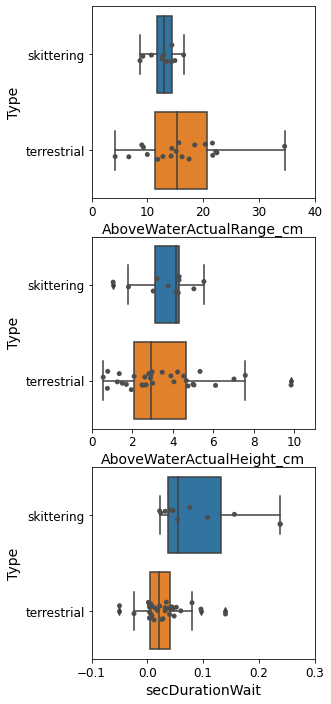

In [77]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=False
                        , sharey='row', figsize=(4,12) )

sns.boxplot(ax=axs[0], y="Type", x="AboveWaterActualRange_cm", data=a,  )
sns.stripplot(ax=axs[0], y="Type", x="AboveWaterActualRange_cm", data=a, color=".3")

axs[0].set_xlim([0, 40])
sns.boxplot(ax=axs[1], y="Type", x="AboveWaterActualHeight_cm", data=a)
sns.stripplot(ax=axs[1], y="Type", x="AboveWaterActualHeight_cm", data=a, color=".3")

axs[1].set_xlim([0, 11])
sns.boxplot(ax=axs[2], y="Type", x="secDurationWait", data=a)
sns.stripplot(ax=axs[2], y="Type", x="secDurationWait", data=a, color=".3")

axs[2].set_xlim([-.1, .3])

<AxesSubplot:xlabel='secDurationPrep', ylabel='Type'>

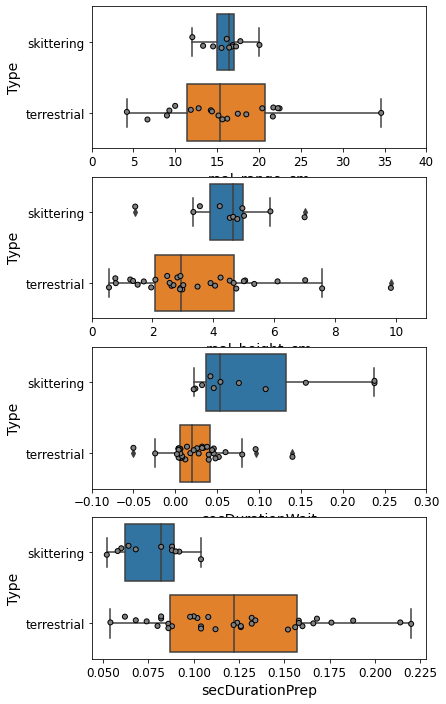

In [91]:
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=False
                        , sharey='row', figsize=(6,12) )

sns.boxplot(ax=axs[0], y="Type", x="real_range_cm", data=a,  )
sns.stripplot(ax=axs[0], y="Type", x="real_range_cm", data=a, color="gray", edgecolor='black', linewidth=1)

axs[0].set_xlim([0, 40])
sns.boxplot(ax=axs[1], y="Type", x="real_height_cm", data=a)
sns.stripplot(ax=axs[1], y="Type", x="real_height_cm", data=a, color="gray", edgecolor='black', linewidth=1)

axs[1].set_xlim([0, 11])
sns.boxplot(ax=axs[2], y="Type", x="secDurationWait", data=a)
sns.stripplot(ax=axs[2], y="Type", x="secDurationWait", data=a, color="gray", edgecolor='black', linewidth=1)

axs[2].set_xlim([-.1, .3])

sns.boxplot(ax=axs[3], y="Type", x="secDurationPrep", data=a)
sns.stripplot(ax=axs[3], y="Type", x="secDurationPrep", data=a,color="gray",  edgecolor='black', linewidth=1)

In [56]:
b = pd.read_excel('../210713_Talia_CricketFrog_forANOVA_allskitteringjumps.xlsx', sheet_name='SkitteringTerrestrialRAW_All', na_values=' ')

In [57]:
b.columns

Index(['ID', 'jmpNo', 'frog', 'Type', 'fps', 'SVL(cm)', 'px/SVL',
       'frameWaterExit', 'frameWaterLand', 'frameDurationAboveWater',
       'secDurationAboveWater', 'jmpHasMaxHeight', 'AboveWaterActualHeight_px',
       'AboveWaterActualHeight_cm', 'AboveWaterActualRange_px',
       'AboveWaterActualRange_cm', 'AboveWaterFitHeight_px',
       'AboveWaterFitHeight_cm', 'AboveWaterFitRange_px',
       'AboveWaterFitRange_cm', 'BAatWC_launch', 'BAatWC_land',
       'framePropStart', 'frameDurationProp', 'secDurationProp',
       'framePrepStart', 'frameDurationPrep', 'secDurationPrep',
       'frameDurationWait', 'secDurationWait', 'BelowWaterRange_after_px',
       'BelowWaterRange_after_cm', 'MaxHeightBelowWater_before_px',
       'MaxHeightBelowWater_before_cm', 'AVG_BelowWater_BA_before',
       'AVG_AboveWater_BA'],
      dtype='object')

In [80]:
a.real_range_cm.dropna().to_numpy()

array([12.03736235, 16.86408451, 20.05748645, 16.7773333 , 14.51932906,
       15.52511182, 13.32403291, 17.26274993, 17.7749874 , 16.15107896,
       16.44595683,  6.67613636, 12.79468573, 21.65755334,  4.22034224,
       15.15993782, 14.2471721 , 17.47400372,  9.98768972, 21.71493255,
       34.59881098,  9.2940983 , 11.85605665,  9.00407231, 22.459653  ,
       20.39582827, 16.20778242, 22.25211923, 18.48238362, 14.38405184,
       15.63454596])

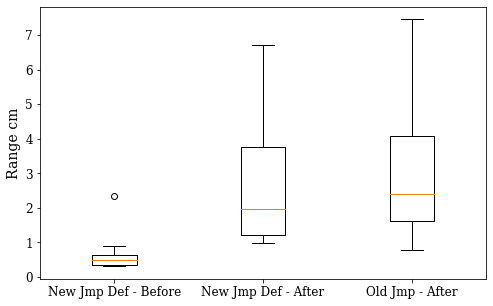

In [91]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot([a.BelowWaterRange_before_cm.dropna().to_numpy(), a.BelowWaterRange_after_cm.dropna().to_numpy(), b.BelowWaterRange_after_cm.dropna().to_numpy()])
ax.set_xticklabels(['New Jmp Def - Before', 'New Jmp Def - After', 'Old Jmp - After'])
ax.set_ylabel('Range cm')
plt.show()

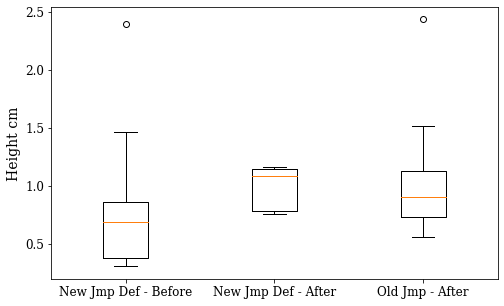

In [94]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot([a.MaxHeightBelowWater_before_cm.dropna().to_numpy(), a.MaxHeightBelowWater_after_cm.dropna().to_numpy(), b.MaxHeightBelowWater_before_cm.dropna().to_numpy()])
ax.set_xticklabels(['New Jmp Def - Before', 'New Jmp Def - After', 'Old Jmp - After'])
ax.set_ylabel('Height cm')
plt.show()

In [121]:
c = b[b.Type=='skittering']
all_skit_totalrange = []
all_skit_totalheight = []
for (theid, row) in c.groupby('ID'):
    no_jmps = len(row)
    for jmp in range(no_jmps):
        #get actual height/range or fit height/range:
        if jmp > 1:
            #means compareable jmp height can exits:
            if !row[row.jmpNo==jmp].AboveWaterActualHeight_cm.hasnans:
                #this means acutal height exits, need to see if prev jmp after height exists:
                if !row[row.jmpNo==jmp - 1].MaxHeightBelowWater
           

4   NaN
Name: AboveWaterFitHeight_cm, dtype: float64
7   NaN
Name: AboveWaterFitHeight_cm, dtype: float64


<AxesSubplot:xlabel='secDurationPrep', ylabel='Type'>

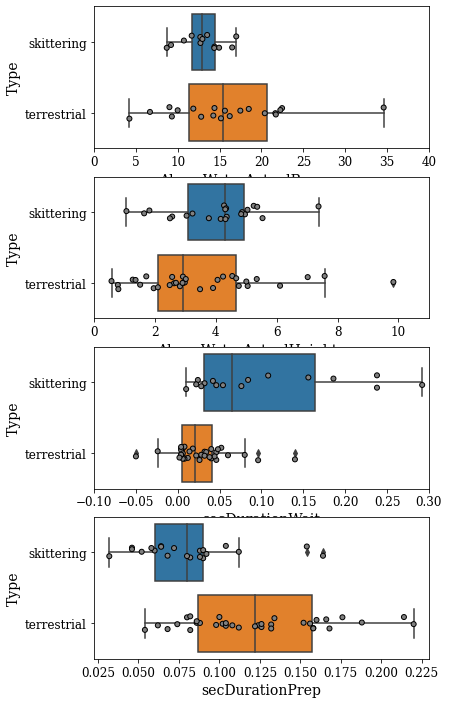

In [48]:
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=False
                        , sharey='row', figsize=(6,12) )

sns.boxplot(ax=axs[0], y="Type", x="AboveWaterActualRange_cm", data=a,  )
sns.stripplot(ax=axs[0], y="Type", x="AboveWaterActualRange_cm", data=a, color="gray", edgecolor='black', linewidth=1)

axs[0].set_xlim([0, 40])
sns.boxplot(ax=axs[1], y="Type", x="AboveWaterActualHeight_cm", data=a)
sns.stripplot(ax=axs[1], y="Type", x="AboveWaterActualHeight_cm", data=a, color="gray", edgecolor='black', linewidth=1)

axs[1].set_xlim([0, 11])
sns.boxplot(ax=axs[2], y="Type", x="secDurationWait", data=a)
sns.stripplot(ax=axs[2], y="Type", x="secDurationWait", data=a, color="gray", edgecolor='black', linewidth=1)

axs[2].set_xlim([-.1, .3])

sns.boxplot(ax=axs[3], y="Type", x="secDurationPrep", data=a)
sns.stripplot(ax=axs[3], y="Type", x="secDurationPrep", data=a,color="gray",  edgecolor='black', linewidth=1)

In [92]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Myriad Pro'
fig.savefig('Figures/TerrestrialVsSkitteringDraft2.pdf', transparent=True)

array([<AxesSubplot:title={'center':'AboveWaterActualRange_cm'}, xlabel='Type'>,
       <AxesSubplot:title={'center':'AboveWaterActualHeight_cm'}, xlabel='Type'>],
      dtype=object)

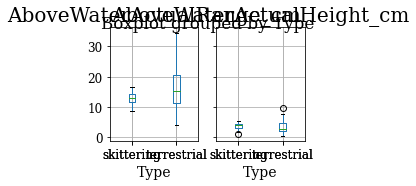

In [9]:
a.boxplot(column=['AboveWaterActualRange_cm', 'AboveWaterActualHeight_cm'], by="Type")

In [19]:
import plotly.express as px

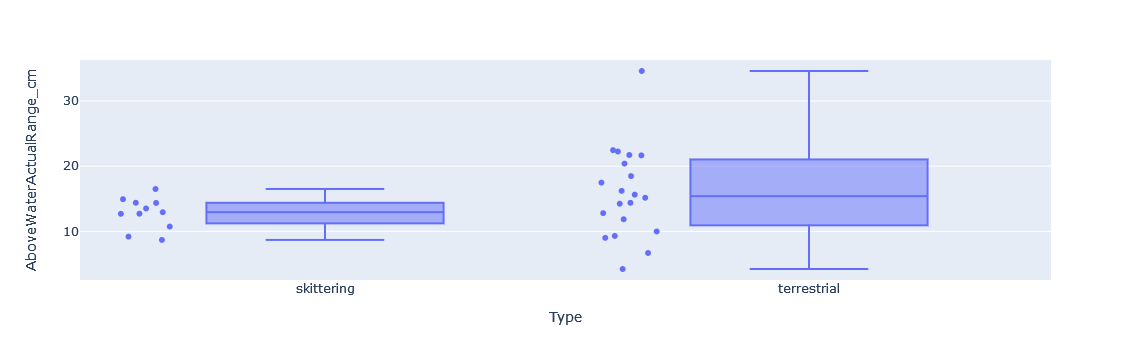

In [21]:
px.box(a, x="Type", y='AboveWaterActualRange_cm', points='all')

In [47]:
import seaborn as sns

(-0.1, 0.3)

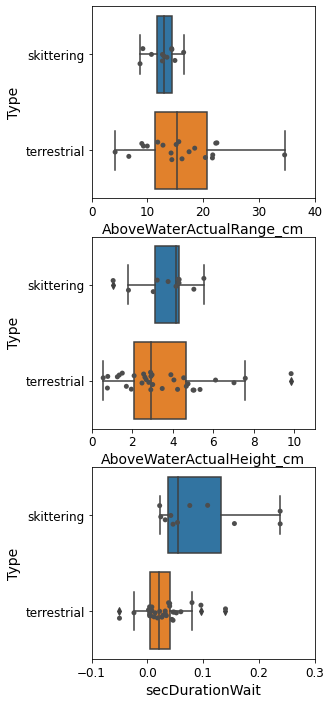

In [44]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=False
                        , sharey='row', figsize=(4,12) )

sns.boxplot(ax=axs[0], y="Type", x="AboveWaterActualRange_cm", data=a,  )
sns.stripplot(ax=axs[0], y="Type", x="AboveWaterActualRange_cm", data=a, color=".3")
#sns.violinplot(ax=axs[0,1], x="Type", y="AboveWaterActualRange_cm", data=a, inner='quartile')
#sns.stripplot(ax=axs[0,1], x="Type", y="AboveWaterActualRange_cm", data=a, color=".3")
axs[0].set_xlim([0, 40])
sns.boxplot(ax=axs[1], y="Type", x="AboveWaterActualHeight_cm", data=a)
sns.stripplot(ax=axs[1], y="Type", x="AboveWaterActualHeight_cm", data=a, color=".3")
#sns.violinplot(ax=axs[1,1], x="Type", y="AboveWaterActualHeight_cm", data=a, inner='quartile')
#sns.stripplot(ax=axs[1,1], x="Type", y="AboveWaterActualHeight_cm", data=a, color=".3")
axs[1].set_xlim([0, 11])
sns.boxplot(ax=axs[2], y="Type", x="secDurationWait", data=a)
sns.stripplot(ax=axs[2], y="Type", x="secDurationWait", data=a, color=".3")
#sns.violinplot(ax=axs[2,1], x="Type", y="secDurationWait", data=a, inner='quartile')
#sns.stripplot(ax=axs[2,1], x="Type", y="secDurationWait", data=a, color=".3")
axs[2].set_xlim([-.1, .3])

In [35]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Myriad Pro'
fig.savefig('Figures/TerrestrialVsSkitteringDraft2.pdf', transparent=True)

In [158]:
!pip install ipympl

You should consider upgrading via the '/home/talcat/.virtualenvs/cricketfrog/bin/python -m pip install --upgrade pip' command.


AC01_05 : (7, 12) - (12, 110) - (110, 155)
[2.13392532]
AC01_06 : (90, 100) - (100, 208) - (208, 285)
[0.42393219]
AC01_10 : (125, 127) - (127, 174) - (174, 215)
[2.02652692]
AC03_04 : (11, 21) - (21, 75) - (75, 101)
[0.45063695]
AC03_15 : (41, 50) - (50, 146) - (146, 221)
[3.85941987]
AC03_18 : (20, 29) - (29, 119) - (119, 176)
[1.49631179]
AC03_20 : (21, 43) - (43, 104) - (104, 196)
[4.11392213]
AC03_21 : (153, 160) - (160, 245) - (245, 423)
[0.93654647]
AC03_22 : (201, 216) - (216, 300) - (300, 478)
[0.14829915]
AC03_23 : (23, 29) - (29, 126) - (126, 187)
[1.06227577]
AC04_03 : (38, 42) - (42, 67) - (67, 127)
[1.47393246]


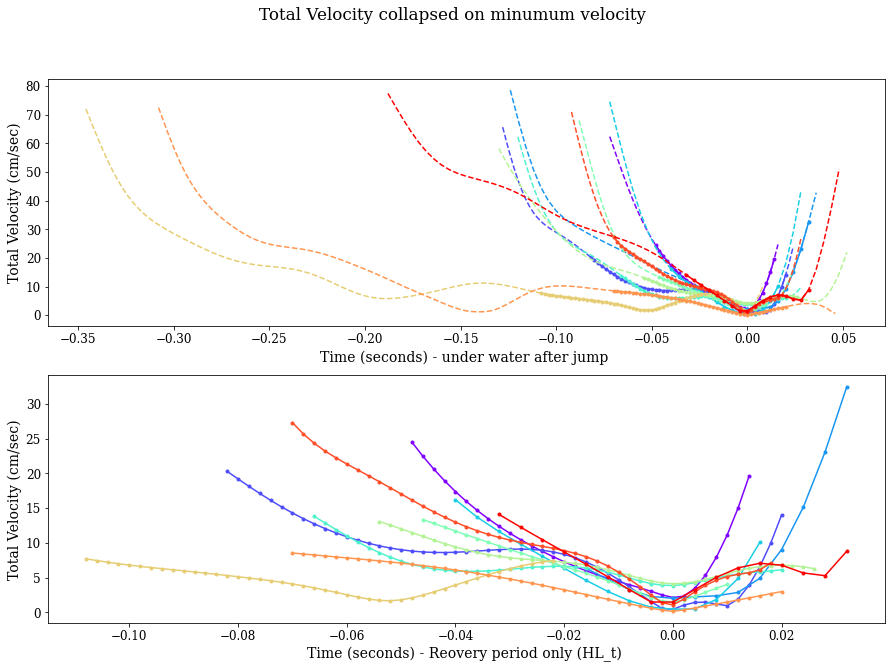

In [98]:
color=iter(cm.rainbow(np.linspace(0,1,len(strict_jump_list))))

fig, ax = plt.subplots(nrows = 2, figsize = (15,10), )

for frog in strict_jump_list:
    c = next(color)
    data = g.loadSingleFrog_wsmoothed(frog) 
    s_mnty = data['s_mnty']
    s_mntx = data['s_mntx']
    s_mnta = data['s_mnta']
    frogsize = data['frogsize(cm)']
      
    
    v_smntx=np.gradient(s_mntx, data['time'])
    v_smnty= np.gradient(s_mnty, data['time'])
    v_total = np.sqrt(v_smntx**2 + v_smnty**2)
    v_angle = np.rad2deg(np.arctan2(v_smnty, v_smntx))
    
    v_smntx =v_smntx/data['pxSVL']*frogsize 
    v_smnty =v_smnty/data['pxSVL']*frogsize
    v_total =v_total/data['pxSVL']*frogsize 
    
    time = data['time']
    frameno = data['frameno']
    
    aboveidx, belowidx = above_below_water_range(data, True)
    
    (aboveidx_s, aboveidx_e) = aboveidx[0]
    (b4_belowidx_s, b4_belowidx_e) = belowidx[0]
    (af_belowidx_s, af_belowidx_e) = belowidx[1]
    print("%s : (%d, %d) - (%d, %d) - (%d, %d)" %(frog, b4_belowidx_s, b4_belowidx_e,
                                                  aboveidx_s, aboveidx_e,
                                                 af_belowidx_s, af_belowidx_e))
    
        
    HL_a = [(list(data['frameno']).index(x), y) for (x, y) in data['HL_a']]
    HL_t = [(list(data['frameno']).index(x), y) for (x, y) in data['HL_t'] if x in data['frameno']]
    
    for prep in HL_t:
        #print(prep)
        #print(data['frameno'][af_belowidx_s], )
        (prep_fr_s, prep_fr_d) = prep
        if prep_fr_s > af_belowidx_s and prep_fr_s < af_belowidx_e:
            pfrs= prep_fr_s
    
    maxV_idx = np.where(v_total == v_total.max())
    propEnd = np.sum(HL_a)
    
    
    minV_idx = np.where(v_total == v_total[b4_belowidx_s:af_belowidx_e].min())
    recrange = (pfrs, pfrs + prep_fr_d)
    #print(recrange)
    print(v_total[minV_idx])
    
    fig.suptitle("Total Velocity collapsed on minumum velocity")
    ax[0].plot(time[af_belowidx_s:af_belowidx_e]-time[minV_idx], v_total[af_belowidx_s:af_belowidx_e], color=c, ls='--' )
    ax[0].plot(time[slice(*recrange)]-time[minV_idx], v_total[slice(*recrange)], color=c, ls='-', marker='.' )
    ax[0].set_xlabel("Time (seconds) - under water after jump ")
    ax[0].set_ylabel("Total Velocity (cm/sec)")
    
    ax[1].plot(time[slice(*recrange)]-time[minV_idx], v_total[slice(*recrange)], color=c, ls='-', marker='.' )
    ax[1].set_xlabel("Time (seconds) - Reovery period only (HL_t) ")
    ax[1].set_ylabel("Total Velocity (cm/sec)")


<AxesSubplot:xlabel='AvgHorVelTotal_cm/sec', ylabel='Count'>

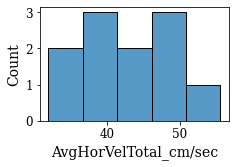

In [77]:
sns.histplot(data=a, x = 'AvgHorVelTotal_cm/sec')

In [79]:
skit = a[a["Type"]== 'skittering']

In [82]:
skit.groupby('frog')

In [84]:
skit["total_hei"] = skit["MaxHeightBelowWater_before_cm"] + skit["AboveWaterActualHeight_cm"]
skit["total_range"] = skit["BelowWaterRange_before_cm"] + skit["AboveWaterActualRange_cm"] + skit["BelowWaterRange_after_cm"]

/home/talcat/.virtualenvs/cricketfrog/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [85]:
skit

ID  JumpNo  frog        Type  SVL(cm)    fps      px/SVL  \
0   AC01_05     NaN  AC01  skittering     2.01  500.0  109.454659   
1   AC01_06     NaN  AC01  skittering     2.01  500.0   92.387000   
2   AC01_10     NaN  AC01  skittering     2.01  250.0   78.758538   
3   AC03_04     NaN  AC03  skittering     2.14  250.0  102.045346   
4   AC03_15     NaN  AC03  skittering     2.14  500.0  105.265898   
5   AC03_18     NaN  AC03  skittering     2.14  500.0   89.250502   
6   AC03_20     NaN  AC03  skittering     2.14  500.0  110.340639   
7   AC03_21     NaN  AC03  skittering     2.14  500.0   96.065096   
8   AC03_22     NaN  AC03  skittering     2.14  500.0   94.061775   
9   AC03_23     NaN  AC03  skittering     2.14  500.0  111.731253   
10  AC04_03     NaN  AC04  skittering     2.23  250.0  110.860816   

    frameWaterExit  frameWaterLand  frameDurationAboveWater  ...  \
0             75.0           173.0                     98.0  ...   
1            119.0           227.0                    108.0  ...   
2            150.0           197.0                     47.0  ...   
3            148.0           202.0                     54.0  ...   
4            102.0           198.0                     96.0  ...   
5            100.0           190.0                     90.0  ...   
6             89.0           150.0                     61.0  ...   
7            212.0           297.0                     85.0  ...   
8            260.0           344.0                     84.0  ...   
9             95.0           192.0                     97.0  ...   
10            69.0            94.0                     25.0  ...   

    AvgHorVelBelow_before_px/sec  AvgHorVelBelow_before_cm/sec  \
0                    1759.194011                     32.305431   
1                    1059.470519                     23.050167   
2                    1289.997757                     32.922088   
3                     738.907714                     15.495685   
4                    1228.981143                     24.984536   
5                    1953.279988                     46.834685   
6                    2650.615976                     51.407335   
7                     928.141275                     20.675796   
8                     625.843914                     14.238579   
9                    1299.249232                     24.884652   
10                   1447.392847                     29.114760   

    AvgHorVelBelow_after_px/sec  AvgHorVelBelow_after_cm/sec  \
0                    599.838706                    11.015299   
1                    597.145285                    12.991677   
2                    789.360675                    20.145307   
3                    523.381185                    10.975863   
4                    444.732420                     9.041175   
5                    429.292149                    10.293334   
6                    654.358423                    12.690945   
7                    541.137183                    12.054676   
8                    546.138704                    12.425205   
9                    644.008179                    12.334754   
10                  1401.957576                    28.200815   

    AvgHorVelTotal_px/sec  AvgHorVelTotal_cm/sec  Unnamed: 61  \
0             2216.507965              40.703439          NaN   
1             1986.188473              43.212128          NaN   
2             2179.407852              55.620761          NaN   
3             2213.533122              46.420156          NaN   
4             1984.486270              40.343556          NaN   
5             2077.438871              49.811699          NaN   
6             1961.759669              38.047321          NaN   
7             1434.330135              31.951943          NaN   
8             1410.028545              32.079568          NaN   
9             2570.442847              49.231952          NaN   
10            2286.914537              46.002001          NaN   

    frame difference

In [88]:
skit.groupby('frog').describe()



JumpNo                              SVL(cm)        ... total_hei  \
      count mean std min 25% 50% 75% max   count  mean  ...       75%   
frog                                                    ...             
AC01    0.0  NaN NaN NaN NaN NaN NaN NaN     3.0  2.01  ...  5.415770   
AC03    0.0  NaN NaN NaN NaN NaN NaN NaN     7.0  2.14  ...  4.898589   
AC04    0.0  NaN NaN NaN NaN NaN NaN NaN     1.0  2.23  ...  1.434118   

               total_range                                             \
           max       count       mean       std        min        25%   
frog                                                                    
AC01  5.876509         3.0  16.319644  4.037686  12.037362  14.450723   
AC03  6.999356         7.0  15.904946  1.575206  13.324033  15.022220   
AC04  1.434118         1.0  16.445957       NaN  16.445957  16.445957   

                                       
            50%        75%        max  
frog                                   
AC01  16.864085  18.460785  20.057486  
AC03  16.151079  17.020042  17.774987  
AC04  16.445957  16.445957  16.445957  

[3 rows x 488 columns]

In [94]:
(skit.groupby('frog').mean()).mean()

JumpNo                                        NaN
SVL(cm)                                  2.126667
fps                                    376.984127
px/SVL                                 101.881905
frameWaterExit                         109.126984
                                          ...    
AvgHorVelTotal_cm/sec                   44.546903
Unnamed: 61                                   NaN
frame differencend prop to fr max v     -1.333333
total_hei                                3.736942
total_range                             16.223516
Length: 61, dtype: float64

In [95]:
(skit.groupby('frog').mean()).std()

JumpNo                                        NaN
SVL(cm)                                  0.110604
fps                                    112.519420
px/SVL                                   8.680893
frameWaterExit                          37.663937
                                          ...    
AvgHorVelTotal_cm/sec                    2.973031
Unnamed: 61                                   NaN
frame differencend prop to fr max v      1.154701
total_hei                                2.008264
total_range                              0.283026
Length: 61, dtype: float64

In [151]:
test_ac03_23 = [86, 93, 101, 120, 138, 166, 186, 208, 224, 259] #500
test_ac03_04 = [136, 144, 149, 158, 164, 185, 200, 210, 216, 226] #250

In [152]:
test_ac03_23_ms = [(x - test_ac03_23[0])/500*1000 for x in test_ac03_23]
test_ac03_04_ms = [(x - test_ac03_04[0])/250*1000 for x in test_ac03_04]

In [153]:
test_ac03_04_ms

[0.0, 32.0, 52.0, 88.0, 112.0, 196.0, 256.0, 296.0, 320.0, 360.0]

In [155]:
test_ac03_23_ms

[0.0, 14.0, 30.0, 68.0, 104.0, 160.0, 200.0, 244.0, 276.0, 346.0]

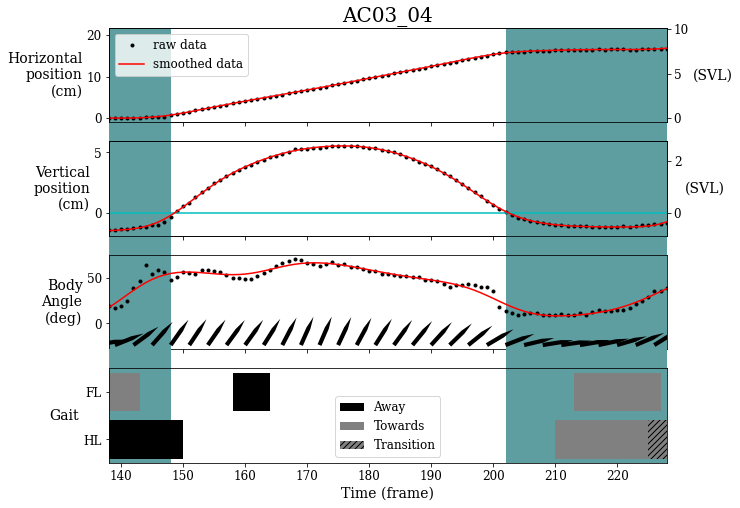

In [148]:
 ax, fig = g.graph_all('AC03_04',  figsize=(10, 8), segment=True, clip=True, time='frame')

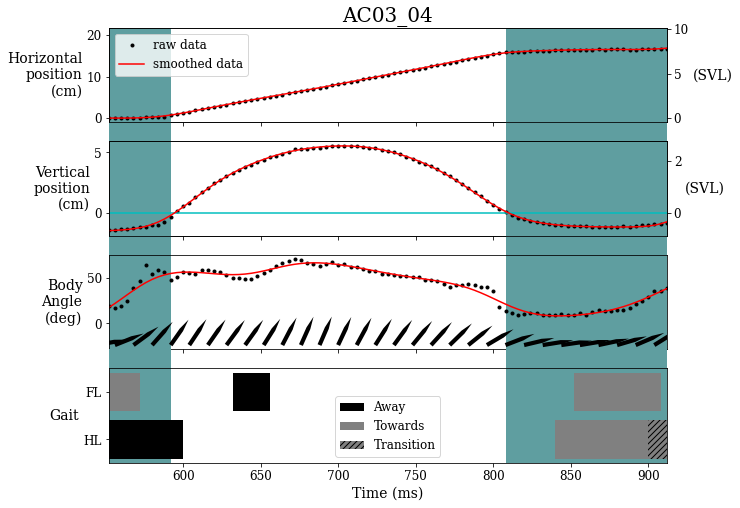

In [149]:
 ax, fig = g.graph_all('AC03_04',  figsize=(10, 8), segment=True, clip=True, time='ms')

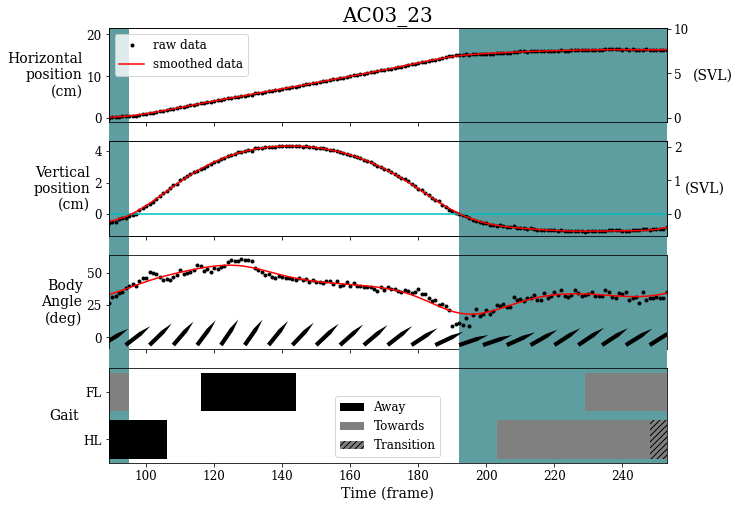

In [150]:
 ax, fig = g.graph_all('AC03_23',  figsize=(10, 8), segment=True, clip=True, time='frame')